# Importazioni e Setup

In questa sezione importiamo le librerie necessarie, configuriamo il path per importare i moduli in `src` e carichiamo il file di configurazione.

In [1]:
# Creare l'environment con tutti i pacchetti installati e le relative versioni
# conda env create -n phish_env -f environment.yml

In [1]:
# Importazioni e Setup
import os
import sys
import yaml
import joblib
import signal
import pandas as pd
import re
import tensorflow as tf
from PIL import Image
import numpy as np
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import json

from src.data_collection import download_phishing_data, download_legit_data
from src.clean_phishing import clean_phishing_sites, format_output
from src.clean import verify_data_integrity
from src.screenshot_capture import batch_capture_screenshots_parallel
from src.parsing import process_directory
from src.merge_results_csvs import merge_and_save_sites, merge_and_save_html_features
from src.feature_extraction import create_features_dataframe, save_features
from src.train_csv_creation import create_final_csv, create_test_csv
from src.ml_models import train_and_predict_random_forest, train_and_predict_xgboost, train_and_predict_lightgbm, train_and_predict_catboost, train_and_predict_logistic_regression, train_and_predict_linear_svm, train_and_predict_mlp
from src.merge_text_data import merge_text_features
from src.clean_text_data import clean_text_features
from src.bert_model import BertPhishingClassifier
from src.cnn_model import train_cnn_model

# Aggiunge la cartella src al path
sys.path.append(os.path.join(os.getcwd(), 'src'))

# Caricamento della configurazione
with open("configs/config.yaml", "r") as f:
    config = yaml.safe_load(f)

print("Setup completato. Percorsi caricati correttamente.")

Setup completato. Percorsi caricati correttamente.


In [3]:
# Crea le directory necessarie
os.makedirs(config["paths"]["raw_legit"], exist_ok=True)
os.makedirs(config["paths"]["raw_phishing"], exist_ok=True)
os.makedirs(config["paths"]["processed"], exist_ok=True)
os.makedirs(config["paths"]["screenshots"], exist_ok=True)
os.makedirs(config["paths"]["screenshots_legit"], exist_ok=True)
os.makedirs(config["paths"]["screenshots_phishing"], exist_ok=True)
os.makedirs(os.path.join(config['paths']['data'], 'raw', 'screenshots'), exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('models/bert', exist_ok=True)

print("Setup completato. Directory create correttamente.")

Setup completato. Directory create correttamente.


# Raccolta dei Dati

In questa sezione richiamiamo le funzioni di download per i dati di siti di phishing e legittimi.

### Download Siti Legittimi
Scarica i dati dei siti legittimi usando CommonCrawl e la lista Tranco.

In [ ]:
def handler(signum, frame):
    print("\n⚠️ Download interrotto manualmente")
    raise KeyboardInterrupt

# Seconda cella: Download dati legittimi
try:
    # Imposta il gestore del segnale CTRL+C
    signal.signal(signal.SIGINT, handler)

    legit_df = download_legit_data(config)
    if legit_df.empty:
        print("⚠️ Nessun sito legittimo scaricato")
    else:
        print(f"✅ Scaricati {len(legit_df)} siti legittimi")
except KeyboardInterrupt:
    print("\n✅ Download interrotto. I dati scaricati finora sono stati salvati")
    print(f"✅ Scaricati {len(legit_df)} siti legittimi")
except Exception as e:
    print(f"🚨 Errore durante il download dei siti legittimi: {e}")
finally:
    # Ripristina il gestore di segnali predefinito
    signal.signal(signal.SIGINT, signal.default_int_handler)

Caricati 10000 domini da Tranco

🌍 Recupero URL per il dominio: codecanyon.net
✅ Trovato e accessibile: https://codecanyon.net/robots.txt
✅ Trovato e accessibile: https://preview.codecanyon.net/robots.txt
🔎 Trovati 2/3 URL validi per codecanyon.net
⏳ Scaricamento di https://codecanyon.net/robots.txt
✅ Salvato data/raw/legit/codecanyon.net_3491c884.html
⏳ Scaricamento di https://preview.codecanyon.net/robots.txt
✅ Salvato data/raw/legit/preview.codecanyon.net_5cce3971.html

🔵 Domini scaricati correttamente: 1 🔵

🌍 Recupero URL per il dominio: sports.ru
✅ Trovato e accessibile: http://www.sports.ru
✅ Trovato e accessibile: https://www.sports.ru/18/
✅ Trovato e accessibile: https://www.sports.ru/1liga/stat/
🔎 Trovati 3/3 URL validi per sports.ru
⏳ Scaricamento di http://www.sports.ru
✅ Salvato data/raw/legit/www.sports.ru_66cbd953.html
⏳ Scaricamento di https://www.sports.ru/18/
✅ Salvato data/raw/legit/www.sports.ru_bd7a11c6.html
⏳ Scaricamento di https://www.sports.ru/1liga/stat/
✅ Salv

### Download Dati di Phishing
Scarica i dati dei siti di phishing dall'URL configurato.

In [ ]:
# Accedi ai percorsi dal file di configurazione
input_file = os.path.join(config["paths"]["external"], "phish_score.csv")
output_file = os.path.join(config["paths"]["external"], "phish_score_cleaned.csv")

# Verifica che il file di input esista prima di procedere
if not os.path.exists(input_file):
    print(f"File {input_file} non trovato!")
else:
    total_records, new_records = clean_phishing_sites(input_file, output_file)
    print(format_output(total_records, new_records, output_file))

    # Rimuovi il file di input dopo aver completato il processo
    if os.path.exists(input_file):
        os.remove(input_file)
        print(f"File {input_file} rimosso con successo.")

Dataset aggiornato e sovrascritto come data/external/phish_score_cleaned.csv. Record totali: 7573
Nuovi record aggiunti: 2151
File data/external/phish_score.csv rimosso con successo.


In [ ]:
# Terza cella: Download dati di phishing
try:
    phishing_df = download_phishing_data(config)
    if phishing_df.empty:
        print("⚠️ Nessun sito di phishing scaricato")
    else:
        print(f"✅ Scaricati {len(phishing_df)} siti di phishing")
except Exception as e:
    print(f"🚨 Errore durante il download dei dati di phishing: {e}")

Caricati 2137 siti di phishing dal file
⏩ URL già processato: https://1111365wz.cc/wap.html

Processando http://allegro.pl-563489234.shop/ (dominio: allegro.pl-563489234.shop)
⚠️ URL non raggiungibile: http://allegro.pl-563489234.shop/
✅ URL rimosso dal file sorgente: http://allegro.pl-563489234.shop/
⏩ URL già processato: http://179.43.152.166/
⏩ URL già processato: https://mondiai-envoi.com/pac/calcul.php
⏩ URL già processato: http://wiki.147474.com

Processando https://paytollykch.vip/ (dominio: paytollykch.vip)
⚠️ URL non raggiungibile: https://paytollykch.vip/
✅ URL rimosso dal file sorgente: https://paytollykch.vip/
⏩ URL già processato: http://144644103365.com

Processando http://999991l.com/ (dominio: 999991l.com)
✅ Salvato data/raw/phishing/999991l.com_ee67e681.html
🔵 Siti phishing scaricati: 1

Processando https://s.team-r.cc/p/gkhs-kwlp/pcbaqqbb/ (dominio: s.team-r.cc)
✅ Salvato data/raw/phishing/s.team-r.cc_10776eaa.html
🔵 Siti phishing scaricati: 2

Processando https://exp

### Pulizia degli html e del csv di phishing

In [ ]:
# Accedi ai path dal file di configurazione
phishing_html_path = config["paths"]["raw_phishing"]
phishing_csv_path = os.path.join(config["paths"]["results"], "phish_sites.csv")

# Controlla se i path esistono
if not os.path.exists(phishing_html_path):
    print(f"❌ Il percorso {phishing_html_path} non esiste!")

if not os.path.exists(phishing_csv_path):
    print(f"❌ Il file CSV {phishing_csv_path} non esiste!")

# Leggi il CSV dei siti di phishing
phish_sites_df = pd.read_csv(phishing_csv_path)
print(f"✅ Caricato il CSV con {len(phish_sites_df)} siti di phishing")

# Lista per tenere traccia dei file da rimuovere
files_to_remove = []
sites_to_keep = []

# Scandisci tutti i file HTML nella cartella
for filename in os.listdir(phishing_html_path):
    if filename.endswith('.html'):
        file_path = os.path.join(phishing_html_path, filename)

        # Leggi il contenuto del file e verifica la dimensione
        try:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                content = file.read()
                if len(content) < 1000:
                    files_to_remove.append(file_path)
                else:
                    # Estrai l'ID del sito dal nome del file (rimuovi l'estensione .html)
                    site_id = filename[:-5]
                    sites_to_keep.append(site_id)
        except Exception as e:
            print(f"⚠️ Errore nella lettura del file {filename}: {str(e)}")

# Rimuovi i file HTML troppo piccoli
for file_path in files_to_remove:
    try:
        os.remove(file_path)
    except Exception as e:
        print(f"⚠️ Errore nella rimozione del file {file_path}: {str(e)}")

print(f"🗑️ Rimossi {len(files_to_remove)} file HTML con meno di 1000 caratteri")

✅ Caricato il CSV con 1062 siti di phishing
🗑️ Rimossi 0 file HTML con meno di 1000 caratteri


In [ ]:
# Verifica l'integrità dei dati
verify_data_integrity()

✅ Dataset integro - Nessuna rimozione necessaria


### Download degli screenshot delle pagine

In [ ]:
# ATTENZIONE: Prima assicurarsi di aver aggiornato sites.csv con i nuovi dati

# Cattura gli screenshot
print("📸 Capturing screenshots of websites for visual analysis...")
screenshot_results = batch_capture_screenshots_parallel(r"data\results\sites.csv", config)
print(f"✅ Screenshots captured and saved. Results in {screenshot_results}")

📸 Capturing screenshots of websites for visual analysis...


2025-04-10 12:18:11,849 - 2025-04-10 12:18:11,849 - Processando 661 siti di 2237 totali
2025-04-10 12:29:57,841 - 2025-04-10 12:29:57,841 - Inizio cattura screenshot per https://www.extra.cz/
2025-04-10 12:30:18,764 - 2025-04-10 12:30:18,764 - Inizio cattura screenshot per https://www.kiabi.com/1-3-droite-n-a_P979112C979117
2025-04-10 12:30:20,706 - 2025-04-10 12:30:20,706 - Inizio cattura screenshot per https://www.icicibank.com?_ga=2.32520190.1158065635.1708975506-830770412.1690930123
2025-04-10 12:30:21,893 - 2025-04-10 12:30:21,893 - Inizio cattura screenshot per http://www.samsonmg.com/
2025-04-10 12:30:24,047 - 2025-04-10 12:30:24,047 - Inizio cattura screenshot per https://quip.com/
2025-04-10 12:30:40,721 - 2025-04-10 12:30:40,721 - ✅ Screenshot salvato: data/raw\screenshots\legit\www.extra.cz_6b585b1a.png
2025-04-10 12:30:41,325 - 2025-04-10 12:30:41,325 - Inizio cattura screenshot per https://us-bank-cancel-transaction.com/verify.php?sessionid=b196e3050b7b8d26d1e0d04000125f75

✅ Screenshots captured and saved. Results in data/raw\screenshots\screenshot_results.csv


### Pulizia degli screenshot (rimozione di quelli di dimensioni troppo ridotte e dei siti bloccati o non raggiungibili)

In [ ]:
# Definisci i percorsi delle cartelle usando il file di configurazione
screenshots_dir = Path(config["paths"]["screenshots"])
legit_dir = Path(config["paths"]["screenshots_legit"])
phishing_dir = Path(config["paths"]["screenshots_phishing"])
results_csv_path = Path(config["paths"]["screenshots_results"])

# Carica il CSV dei risultati degli screenshot
if results_csv_path.exists():
    results_df = pd.read_csv(results_csv_path)
    print(f"✅ Caricato il CSV con {len(results_df)} record")
else:
    print(f"❌ Il file {results_csv_path} non esiste!")
    exit(1)

# Contatori per le statistiche
total_screenshots = 0
removed_screenshots = 0
files_to_remove = []
image_dimensions = []

# Funzione per verificare l'altezza dell'immagine e raccogliere le dimensioni
def check_and_process_image(image_path):
    global total_screenshots, removed_screenshots
    total_screenshots += 1

    try:
        with Image.open(image_path) as img:
            width, height = img.size

            if height < 500:
                files_to_remove.append(image_path)
                return False
            else:
                image_dimensions.append((width, height))
                return True
    except Exception as e:
        print(f"⚠️ Errore nell'apertura dell'immagine {image_path}: {e}")
        files_to_remove.append(image_path)
        return False

# Processa tutte le immagini nelle directory
print("🔍 Verifica delle immagini in corso...")

# Controlla le immagini in entrambe le directory
legit_images = list(legit_dir.glob("*.png"))
phishing_images = list(phishing_dir.glob("*.png"))

all_images = legit_images + phishing_images
for image_path in all_images:
    check_and_process_image(image_path)

# Calcola le dimensioni medie
if image_dimensions:
    mean_width = int(np.mean([dim[0] for dim in image_dimensions]))
    mean_height = int(np.mean([dim[1] for dim in image_dimensions]))
    print(f"📏 Dimensioni medie delle immagini: {mean_width}x{mean_height} pixel")
else:
    mean_width, mean_height = 800, 600  # Default fallback
    print(f"⚠️ Non è stato possibile calcolare le dimensioni medie, usando: {mean_width}x{mean_height} pixel")

# Ridimensiona tutte le immagini alle dimensioni medie
resized_count = 0
for image_path in all_images:
    if image_path not in files_to_remove and os.path.exists(image_path):
        try:
            with Image.open(image_path) as img:
                # Ridimensiona l'immagine mantenendo l'aspect ratio
                img_resized = img.resize((mean_width, mean_height), Image.LANCZOS)
                img_resized.save(image_path)
                resized_count += 1
        except Exception as e:
            print(f"⚠️ Errore nel ridimensionamento dell'immagine {image_path}: {e}")

print(f"✅ Ridimensionate {resized_count} immagini alle dimensioni {mean_width}x{mean_height} pixel")

# Rimuovi i file dalla lista dei risultati CSV
rows_to_remove = []
for i, row in results_df.iterrows():
    screenshot_path = row['screenshot_path']
    # Converte il percorso nel formato Path per confronto uniforme
    path_obj = Path(screenshot_path)

    if path_obj in files_to_remove or not path_obj.exists():
        rows_to_remove.append(i)

# Elimina i file fisicamente
removed_screenshots = 0
for file_path in files_to_remove:
    try:
        os.remove(file_path)
        removed_screenshots += 1
    except Exception as e:
        print(f"⚠️ Errore nell'eliminazione del file {file_path}: {e}")

# Aggiorna il DataFrame rimuovendo le righe corrispondenti
if rows_to_remove:
    results_df = results_df.drop(rows_to_remove)

    # Salva il file CSV aggiornato
    results_df.to_csv(results_csv_path, index=False)
    print(f"💾 File {results_csv_path} aggiornato con {len(results_df)} record totali")

# Statistiche finali
print("\n📊 Statistiche finali:")
print(f"- Screenshot totali esaminati: {total_screenshots}")
print(f"- Screenshot rimossi (altezza < 500px): {removed_screenshots}")
print(f"- Screenshot rimanenti: {total_screenshots - removed_screenshots}")
print(f"- Screenshot ridimensionati: {resized_count}")

# Statistiche per categoria
legit_remaining = len(list(legit_dir.glob("*.png")))
phishing_remaining = len(list(phishing_dir.glob("*.png")))
print(f"- Screenshot legittimi rimanenti: {legit_remaining}")
print(f"- Screenshot di phishing rimanenti: {phishing_remaining}")

✅ Caricato il CSV con 2180 record
🔍 Verifica delle immagini in corso...
📏 Dimensioni medie delle immagini: 1395x1121 pixel
✅ Ridimensionate 1910 immagini alle dimensioni 1395x1121 pixel
💾 File data\raw\screenshots\screenshot_results.csv aggiornato con 1910 record totali

📊 Statistiche finali:
- Screenshot totali esaminati: 2180
- Screenshot rimossi (altezza < 500px): 270
- Screenshot rimanenti: 1910
- Screenshot ridimensionati: 1910
- Screenshot legittimi rimanenti: 1068
- Screenshot di phishing rimanenti: 842


### Verifica degli screenshot e del csv

In [ ]:
# Definisci i percorsi dalle voci di configurazione
screenshots_dir = Path(config["paths"]["screenshots"])
results_csv_path = Path(config["paths"]["screenshots_results"])

print(f"🔍 Verificando la coerenza tra gli screenshot e {results_csv_path}")

# Verifico se il file CSV esiste
if not results_csv_path.exists():
    print(f"❌ Il file {results_csv_path} non esiste!")
else:
    # Carico il CSV dei risultati degli screenshot
    results_df = pd.read_csv(results_csv_path)
    print(f"✅ Caricato il CSV con {len(results_df)} record")
    print("Colonne disponibili:", results_df.columns.tolist())

    # Recupero tutti i file di screenshot nelle cartelle
    legit_dir = Path(config["paths"]["screenshots_legit"])
    phishing_dir = Path(config["paths"]["screenshots_phishing"])

    legit_files = set([file.name for file in legit_dir.glob("*.png")])
    phishing_files = set([file.name for file in phishing_dir.glob("*.png")])

    print(f"📸 Trovati {len(legit_files)} screenshot legittimi e {len(phishing_files)} screenshot di phishing")

    # Estrai i nomi dei file dai percorsi completi nel CSV
    csv_files = set()
    for path in results_df['screenshot_path']:
        # Prendi solo il nome del file dal percorso completo
        filename = Path(path).name if isinstance(path, str) else ""
        if filename:
            csv_files.add(filename)

    # Trovo i file che sono presenti nelle cartelle ma non nel CSV
    missing_in_csv = (legit_files.union(phishing_files)) - csv_files

    # Trovo i record che sono nel CSV ma non hanno il file corrispondente
    missing_files = csv_files - (legit_files.union(phishing_files))

    # Aggiunta di nuovi record per i file mancanti nel CSV
    new_records = []
    for filename in missing_in_csv:
        is_phishing = filename in phishing_files  # True se è in phishing_files
        domain = filename.split('_')[0] if '_' in filename else filename.replace(".png", "")
        hash_id = filename.split('_')[1].replace(".png", "") if '_' in filename else ""

        # Crea il percorso completo per lo screenshot
        if is_phishing:
            screenshot_path = str(phishing_dir / filename)
        else:
            screenshot_path = str(legit_dir / filename)

        new_records.append({
            'screenshot_path': screenshot_path,
            'domain': domain,
            'hash_id': hash_id,
            'is_phishing': int(is_phishing)
        })

    if new_records:
        # Aggiungi i nuovi record al DataFrame
        results_df = pd.concat([results_df, pd.DataFrame(new_records)], ignore_index=True)
        print(f"➕ Aggiunti {len(new_records)} nuovi record al CSV")

    # Rimuovi i record che non hanno il file corrispondente
    if missing_files:
        to_remove = []
        for i, row in results_df.iterrows():
            path = row['screenshot_path']
            filename = Path(path).name if isinstance(path, str) else ""
            if filename in missing_files:
                to_remove.append(i)

        if to_remove:
            results_df = results_df.drop(to_remove)
            print(f"➖ Rimossi {len(to_remove)} record senza screenshot")

    # Salva il file CSV aggiornato
    results_df.to_csv(results_csv_path, index=False)
    print(f"💾 File {results_csv_path} aggiornato con {len(results_df)} record totali")

    # Statistiche finali
    print("\n📊 Statistiche finali:")
    print(f"- Screenshot legittimi: {len(legit_files)}")
    print(f"- Screenshot di phishing: {len(phishing_files)}")
    print(f"- Record nel CSV: {len(results_df)}")

🔍 Verificando la coerenza tra gli screenshot e data\raw\screenshots\screenshot_results.csv
✅ Caricato il CSV con 1910 record
Colonne disponibili: ['screenshot_path', 'domain', 'hash_id', 'is_phishing']
📸 Trovati 1068 screenshot legittimi e 842 screenshot di phishing
💾 File data\raw\screenshots\screenshot_results.csv aggiornato con 1910 record totali

📊 Statistiche finali:
- Screenshot legittimi: 1068
- Screenshot di phishing: 842
- Record nel CSV: 1910


# Parsing dei Contenuti e Feature Extraction

Estraiamo le feature dai dati processati (HTML, URL e immagini).

In [ ]:
phishing_html_path = config['paths']['raw_phishing']
legit_html_path = config['paths']['raw_legit']

# Output paths
phishing_numeric = os.path.join(config["paths"]["processed"], "html_phishing_numeric.csv")
phishing_text = os.path.join(config["paths"]["processed"], "html_phishing_text.csv")
legit_numeric = os.path.join(config["paths"]["processed"], "html_legit_numeric.csv")
legit_text = os.path.join(config["paths"]["processed"], "html_legit_text.csv")

# Eseguiamo il parsing
print("Parsing siti di phishing...")
phish_df_num, phish_df_text = process_directory(
    phishing_html_path,
    phishing_numeric,
    phishing_text,
    is_phishing=True
)
print(f"Processati {len(phish_df_num)} siti di phishing")

print("\nParsing siti legittimi...")
legit_df_num, legit_df_text = process_directory(
    legit_html_path,
    legit_numeric,
    legit_text,
    is_phishing=False
)
print(f"Processati {len(legit_df_num)} siti legittimi")

Parsing siti di phishing...
Processati 1062 siti di phishing

Parsing siti legittimi...
Processati 1175 siti legittimi


### Creiamo *sites.csv*, *html_features.csv* e *url_features.csv*

In [ ]:
# Merge legit and phishing sites
print("Merging legitimate and phishing sites...")

# Input paths are already defined in config
legit_path = os.path.join('data', 'results', 'legit_sites.csv')
phish_path = os.path.join('data', 'results', 'phish_sites.csv')
output_path = os.path.join('data', 'results', 'sites.csv')

# Merge the sites files
merge_and_save_sites(legit_path, phish_path, output_path)
print(f"Sites merged and saved to {output_path}")

Merging legitimate and phishing sites...
Sites merged and saved to data\results\sites.csv


In [ ]:
# Merge HTML features
print("\nMerging HTML features...")
processed_dir = os.path.join(config["paths"]["processed"])
training_dir = os.path.join(config["paths"]["trainingdata"])

legit_numeric_path = os.path.join(processed_dir, "html_legit_numeric.csv")
phish_numeric_path = os.path.join(processed_dir, "html_phishing_numeric.csv")
html_features_path = os.path.join(training_dir, "html_features.csv")

merge_and_save_html_features(legit_numeric_path, phish_numeric_path, html_features_path)
print(f"HTML features merged and saved to {html_features_path}")


Merging HTML features...
HTML features merged and saved to data/trainingdata\html_features.csv


In [ ]:
# Then proceed with feature extraction
print("\nExtracting features...")

# Extract features from the merged sites
input_path = os.path.join('data', 'results', 'sites.csv')
output_path = os.path.join('data', 'trainingdata', 'url_features.csv')

# Extract features
url_features_df = create_features_dataframe(input_path)

# Save features to CSV
save_features(url_features_df, output_path)
print(f"Features extracted and saved to {output_path}")


Extracting features...
Features extracted and saved to data\trainingdata\url_features.csv


## Unione dei csv html e url

In [ ]:
# Creiamo merged_features.csv
print("🔄 Unione dei dati di URL e HTML...")
sites_csv = os.path.join(config["paths"]["results"], "sites.csv")
training_dir = os.path.join(config["paths"]["trainingdata"])
output_path = os.path.join(training_dir, "merged_features.csv")

create_final_csv(sites_csv)
print(f"✅ File merged_features.csv creato in {output_path}")

Processati 10 record su 2237
Processati 20 record su 2237
Processati 30 record su 2237
..................................................
Processati 2210 record su 2237
Processati 2220 record su 2237
Processati 2230 record su 2237
Elaborazione completata. Risultati salvati in data\trainingdata\merged_features.csv


,f1_url_length,f2_hostname_length,f3_has_ip,f4_dot,f5_hyphen,f6_at,f7_question,f8_ampersand,f9_pipe,f10_equal,...,f90_dom_leaf_ratio,f91_external_css,f92_inline_styles,f93_style_tags,f94_inline_events,f95_obfuscated_events,f96_internal_resources,f97_external_resources,f98_external_resource_ratio,is_phishing
0,37,23,0,1,0,0,0,0,0,0,...,0.308411,0,33,2,0,0,19,25,0.568182,1
1,16,9,0,1,0,0,0,0,0,0,...,0.219959,1,38,45,0,0,6,2,0.250000,0
2,19,10,0,1,0,0,0,0,0,0,...,0.633333,1,2,0,2,0,4,0,0.000000,1
3,35,19,0,2,0,0,1,0,0,1,...,0.140780,0,1,1,1,0,121,16,0.116788,0
4,22,13,0,1,0,0,0,0,0,0,...,0.763158,1,0,0,0,0,11,2,0.153846,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,15,8,0,1,0,0,0,0,0,0,...,0.376623,1,1,1,6,0,8,1,0.111111,1
2233,25,8,0,1,0,0,0,0,0,0,...,0.127983,4,14,0,2,0,13,0,0.000000,0
2234,23,14,0,2,0,0,0,0,0,0,...,0.359050,4,1,0,1,0,68,8,0.105263,0
2235,85,23,0,2,1,0,0,0,0,0,...,0.273775,6,8,1,0,0,0,26,1.000000,1


# Analisi con Modelli di Machine Learning

In questa sezione addestriamo ed effettuiamo la valutazione dei modelli ML.

## Feature URL + numeriche HTML

### Random Forest

In [4]:
#Random Forest model su dataset di test
print("🌳 Addestramento del modello Random Forest...")

train_data_path = os.path.join(config["paths"]["trainingdata"], "merged_features.csv")
predict_data_path = os.path.join(config["paths"]["trainingdata"], "test_features.csv")

# Addestra e valuta il modello
results = train_and_predict_random_forest(train_data_path, predict_data_path)

# Print the results
print("Predict su dataset di test")
print("Classification Report:")
print(results['classification_report'])

print("\nConfusion Matrix:")
print(results['confusion_matrix'])

print("\nTop 10 Most Important Features:")
print(results['feature_importance'].head(10))

🌳 Addestramento del modello Random Forest...
Predict su dataset di test
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       145
           1       0.69      0.84      0.76        44

    accuracy                           0.87       189
   macro avg       0.82      0.86      0.83       189
weighted avg       0.89      0.87      0.88       189


Confusion Matrix:
[[128  17]
 [  7  37]]

Top 10 Most Important Features:
                         feature  importance
66               f67_links_count    0.074995
57    f58_external_domains_count    0.070808
89            f90_dom_leaf_ratio    0.063204
88                 f89_dom_nodes    0.047148
26     f27_ratio_digits_hostname    0.045143
20                       f21_www    0.042198
55           f56_https_resources    0.032779
46  f49_avg_word_length_hostname    0.029960
87                 f88_dom_depth    0.029654
65              f66_images_count    0.026303


In [5]:
# Estrai il modello dal dizionario dei risultati
rf_model = results['model']
model_path = os.path.join('models', 'random_forest.pkl')
joblib.dump(rf_model, model_path)
print(f"✅ Modello Random Forest salvato con successo in '{model_path}'")

✅ Modello Random Forest salvato con successo in 'models\random_forest.pkl'


### XGBoost

In [5]:
#XGBoost model su dataset di test
print("🌲 Addestramento del modello XGBoost...")

# Usa i percorsi dal file di configurazione
train_data_path = os.path.join(config["paths"]["trainingdata"], "merged_features.csv")
predict_data_path = os.path.join(config["paths"]["trainingdata"], "test_features.csv")

# Addestra e valuta il modello
#{'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
xgb_results = train_and_predict_xgboost(train_data_path, predict_data_path)

# Print the results
print("Predict su dataset di test")
print("Classification Report:")
print(xgb_results['classification_report'])

print("\nConfusion Matrix:")
print(xgb_results['confusion_matrix'])

print("\nTop 10 Most Important Features:")
print(xgb_results['feature_importance'].head(10))

🌲 Addestramento del modello XGBoost...
Predict su dataset di test
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       145
           1       0.63      0.84      0.72        44

    accuracy                           0.85       189
   macro avg       0.79      0.84      0.81       189
weighted avg       0.87      0.85      0.85       189


Confusion Matrix:
[[123  22]
 [  7  37]]

Top 10 Most Important Features:
                       feature  importance
57  f58_external_domains_count    0.090557
36          f37_path_extension    0.053127
20                     f21_www    0.043655
66             f67_links_count    0.041983
26   f27_ratio_digits_hostname    0.034541
89          f90_dom_leaf_ratio    0.025349
88               f89_dom_nodes    0.021404
73           f74_total_cookies    0.020175
40     f41_max_char_repeat_url    0.019807
24                   f25_https    0.016614


In [6]:
model_path = os.path.join('models', 'xgboost.pkl')
joblib.dump(xgb_results['model'], model_path)
print(f"✅ Modello XGBoost salvato con successo in '{model_path}'")

✅ Modello XGBoost salvato con successo in 'models\xgboost.pkl'


### LightGBM

In [8]:
#LightGBM model su dataset di test
print("🌿 Addestramento del modello LightGBM...")

# Usa i percorsi dal file di configurazione
train_data_path = os.path.join(config["paths"]["trainingdata"], "merged_features.csv")
predict_data_path = os.path.join(config["paths"]["trainingdata"], "test_features.csv")

# Addestra e valuta il modello
lgb_results = train_and_predict_lightgbm(train_data_path, predict_data_path)

# Print the results
print("Predict su dataset di test")
print("Classification Report:")
print(lgb_results['classification_report'])

print("\nConfusion Matrix:")
print(lgb_results['confusion_matrix'])

print("\nTop 10 Most Important Features:")
print(lgb_results['feature_importance'].head(10))

🌿 Addestramento del modello LightGBM...
[LightGBM] [Info] Number of positive: 1062, number of negative: 1175
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3594
[LightGBM] [Info] Number of data points in the train set: 2237, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.474743 -> initscore=-0.101114
[LightGBM] [Info] Start training from score -0.101114
..................................................
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Predict su dataset di test
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       145
           1       0.58      0.80      0.67        44

    accuracy                           0.82       189
   macro av

In [9]:
model_path = os.path.join('models', 'lightgbm.pkl')
joblib.dump(lgb_results['model'], model_path)
print(f"✅ Modello LightGBM salvato con successo in '{model_path}'")

✅ Modello LightGBM salvato con successo in 'models\lightgbm.pkl'


### CatBoost

In [4]:
#CatBoost model su dataset di test
print("🐱 Addestramento del modello CatBoost...")

# Usa i percorsi dal file di configurazione
train_data_path = os.path.join(config["paths"]["trainingdata"], "merged_features.csv")
predict_data_path = os.path.join(config["paths"]["trainingdata"], "test_features.csv")

# Addestra e valuta il modello
cat_results = train_and_predict_catboost(train_data_path, predict_data_path)

# Print the results
print("Predict su dataset di test")
print("Classification Report:")
print(cat_results['classification_report'])

print("\nConfusion Matrix:")
print(cat_results['confusion_matrix'])

print("\nTop 10 Most Important Features:")
print(cat_results['feature_importance'].head(10))

🐱 Addestramento del modello CatBoost...
Predict su dataset di test
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       145
           1       0.71      0.82      0.76        44

    accuracy                           0.88       189
   macro avg       0.82      0.86      0.84       189
weighted avg       0.89      0.88      0.88       189


Confusion Matrix:
[[130  15]
 [  8  36]]

Top 10 Most Important Features:
                         feature  importance
57    f58_external_domains_count    7.838420
26     f27_ratio_digits_hostname    7.124420
89            f90_dom_leaf_ratio    5.010332
66               f67_links_count    4.845404
20                       f21_www    4.275726
46  f49_avg_word_length_hostname    3.433067
45     f46_longest_word_hostname    3.213048
97   f98_external_resource_ratio    2.840137
88                 f89_dom_nodes    2.704923
59            f60_inline_scripts    2.277217


In [5]:
model_path = os.path.join('models', 'catboost.pkl')
joblib.dump(cat_results['model'], model_path)
print(f"✅ Modello CatBoost salvato con successo in '{model_path}'")

✅ Modello CatBoost salvato con successo in 'models\catboost.pkl'


### Logistic Regression

In [12]:
#Logistic Regression model su dataset di test
print("📊 Addestramento del modello Logistic Regression...")

# Usa i percorsi dal file di configurazione
train_data_path = os.path.join(config["paths"]["trainingdata"], "merged_features.csv")
predict_data_path = os.path.join(config["paths"]["trainingdata"], "test_features.csv")

# Addestra e valuta il modello
lr_results = train_and_predict_logistic_regression(train_data_path, predict_data_path)

# Print the results
print("Predict su dataset di test")
print("Classification Report:")
print(lr_results['classification_report'])

print("\nConfusion Matrix:")
print(lr_results['confusion_matrix'])

print("\nTop 10 Most Important Features:")
print(lr_results['feature_importance'].head(10))

📊 Addestramento del modello Logistic Regression...
Predict su dataset di test
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       145
           1       0.55      0.77      0.64        44

    accuracy                           0.80       189
   macro avg       0.73      0.79      0.75       189
weighted avg       0.83      0.80      0.81       189


Confusion Matrix:
[[117  28]
 [ 10  34]]

Top 10 Most Important Features:
                      feature  importance
36         f37_path_extension    2.389424
26  f27_ratio_digits_hostname    2.321685
89         f90_dom_leaf_ratio    2.203059
20                    f21_www    2.098973
24                  f25_https    1.955680
68      f69_language_mismatch    1.514155
33          f34_prefix_suffix    1.293662
17              f18_semicolon    1.289607
25       f26_ratio_digits_url    1.225910
32         f33_num_subdomains    1.149078


c:\Users\lalberti\AppData\Local\miniconda3\envs\phish_env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
model_path = os.path.join('models', 'logistic_regression.pkl')
joblib.dump(lr_results['model'], model_path)
print(f"✅ Modello Logistic Regression salvato con successo in '{model_path}'")

✅ Modello Logistic Regression salvato con successo in 'models\logistic_regression.pkl'


### Linear SVM

In [14]:
#SVM model su dataset di test
print("⚔️ Addestramento del modello Linear SVM...")

# Usa i percorsi dal file di configurazione
train_data_path = os.path.join(config["paths"]["trainingdata"], "merged_features.csv")
predict_data_path = os.path.join(config["paths"]["trainingdata"], "test_features.csv")

# Addestra e valuta il modello
svm_results = train_and_predict_linear_svm(train_data_path, predict_data_path)

# Print the results
print("Predict su dataset di test")
print("Classification Report:")
print(svm_results['classification_report'])

print("\nConfusion Matrix:")
print(svm_results['confusion_matrix'])

print("\nTop 10 Most Important Features:")
print(svm_results['feature_importance'].head(10))

⚔️ Addestramento del modello Linear SVM...
Predict su dataset di test
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81       145
           1       0.46      0.80      0.58        44

    accuracy                           0.74       189
   macro avg       0.69      0.76      0.69       189
weighted avg       0.81      0.74      0.75       189


Confusion Matrix:
[[104  41]
 [  9  35]]

Top 10 Most Important Features:
                      feature  importance
26  f27_ratio_digits_hostname    1.795818
36         f37_path_extension    1.665616
5                       f6_at    1.346534
89         f90_dom_leaf_ratio    0.941492
33          f34_prefix_suffix    0.785539
27               f28_punycode    0.726522
79           f80_has_ssl_seal    0.682584
52     f53_brand_in_subdomain    0.619673
31     f32_abnormal_subdomain    0.568131
20                    f21_www    0.541221


In [15]:
model_path = os.path.join('models', 'linear_svm.pkl')
joblib.dump(svm_results['model'], model_path)
print(f"✅ Modello Linear SVM salvato con successo in '{model_path}'")

✅ Modello Linear SVM salvato con successo in 'models\linear_svm.pkl'


### Multi-layer Perceptron

In [6]:
#MLP model su dataset di test
print("🧠 Addestramento del modello Multi-layer Perceptron...")

# Usa i percorsi dal file di configurazione
train_data_path = os.path.join(config["paths"]["trainingdata"], "merged_features.csv")
predict_data_path = os.path.join(config["paths"]["trainingdata"], "test_features.csv")

# Addestra e valuta il modello
mlp_results = train_and_predict_mlp(train_data_path, predict_data_path)

# Print the results
print("Predict su dataset di test")
print("Classification Report:")
print(mlp_results['classification_report'])

print("\nConfusion Matrix:")
print(mlp_results['confusion_matrix'])

print("\nTop 10 Most Important Features:")
print(mlp_results['feature_importance'].head(10))

🧠 Addestramento del modello Multi-layer Perceptron...
Predict su dataset di test
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       145
           1       0.67      0.75      0.71        44

    accuracy                           0.86       189
   macro avg       0.80      0.82      0.81       189
weighted avg       0.86      0.86      0.86       189


Confusion Matrix:
[[129  16]
 [ 11  33]]

Top 10 Most Important Features:
                      feature  importance
36         f37_path_extension   36.342040
26  f27_ratio_digits_hostname   35.786690
81         f82_data_uri_count   35.757854
54         f55_suspicious_tld   32.627762
20                    f21_www   29.250517
5                       f6_at   29.177325
52     f53_brand_in_subdomain   28.558142
79           f80_has_ssl_seal   28.422766
69               f70_h1_count   26.991551
68      f69_language_mismatch   26.185531


In [7]:
model_path = os.path.join('models', 'mlp.pkl')
joblib.dump(mlp_results['model'], model_path)
print(f"✅ Modello Multi-layer Perceptron salvato con successo in '{model_path}'")

✅ Modello Multi-layer Perceptron salvato con successo in 'models\mlp.pkl'


## Feature testuali HTML/HTML interi

### BERT

In [7]:
# Unisci i dati testuali
print("📝 Unione dei dati testuali HTML per addestramento BERT...")

# Recupera i percorsi dai file di configurazione
processed_dir = os.path.join(config["paths"]["processed"])
legit_text_path = os.path.join(processed_dir, "html_legit_text.csv")
phishing_text_path = os.path.join(processed_dir, "html_phishing_text.csv")

# Unisci i dati testuali
merged_df = merge_text_features(legit_text_path, phishing_text_path)
print(f"✅ Dati testuali uniti: {len(merged_df)} record totali")

# Visualizza la distribuzione delle classi
n_legit = len(merged_df[merged_df['is_phishing'] == 0])
n_phish = len(merged_df[merged_df['is_phishing'] == 1])
print(f"📊 Distribuzione delle classi: {n_legit} legittime ({n_legit/len(merged_df)*100:.1f}%), "
      f"{n_phish} phishing ({n_phish/len(merged_df)*100:.1f}%)")

# Pulisci i dati
print("\n🧹 Pulizia dei dati testuali...")
cleaned_df = clean_text_features(merged_df)
print(f"✅ Dati testuali puliti: {len(cleaned_df)} record")

# Prepara i dati per BERT
X = cleaned_df['text_combined'].tolist()
y = cleaned_df['is_phishing'].tolist()
print(f"✅ Dati pronti per l'addestramento BERT")

# Salva i dati uniti e puliti
output_path = os.path.join(config["paths"]["trainingdata"], "bert_training_data.csv")
cleaned_df.to_csv(output_path, index=False)
print(f"💾 Dati salvati in: {output_path}")

📝 Unione dei dati testuali HTML per addestramento BERT...
✅ Dati testuali uniti: 2237 record totali
📊 Distribuzione delle classi: 1175 legittime (52.5%), 1062 phishing (47.5%)

🧹 Pulizia dei dati testuali...
✅ Dati testuali puliti: 2237 record
✅ Dati pronti per l'addestramento BERT
💾 Dati salvati in: data/trainingdata/bert_training_data.csv


In [ ]:
# 2. Istanzia il classificatore
bert_classifier = BertPhishingClassifier()

# 3. Allena il modello su tutto il dataset
bert_classifier.train(X, y, epochs=3)

In [ ]:
bert_classifier = BertPhishingClassifier.from_pretrained("models/bert")

In [35]:
# Salva il modello BERT
bert_classifier.model.save_pretrained('models/bert')
bert_classifier.tokenizer.save_pretrained('models/bert')

print("Modello BERT salvato con successo in 'models/bert'")

Modello BERT salvato con successo in 'models/bert'


#### Predizione su un dataset di test scaricato da HuggingFace

In [9]:
# Carica il file che contiene la colonna html_path
df_html_test = pd.read_csv("data/processed/html_test_text.csv")

# Carica il file di riferimento che contiene html_file e is_phishing
df_reference = pd.read_csv("data/results/test.csv")

# Unisci i due DataFrame in base alla corrispondenza tra html_path e html_file,
# così da ottenere la colonna is_phishing nel DataFrame df_html_test.
df_merged = pd.merge(
    df_html_test,
    df_reference[["html_file", "is_phishing"]],
    left_on="html_path",
    right_on="html_file",
    how="left"
)

# Se non serve più la colonna html_file duplicata, la rimuoviamo
df_merged.drop(columns=["html_file", "html_path"], inplace=True)

# Verifica se ci sono valori NaN nella colonna is_phishing (caso in cui non siano stati trovati match)
num_unmatched = df_merged["is_phishing"].isna().sum()
if num_unmatched > 0:
    print(f"Attenzione: {num_unmatched} righe non hanno trovato corrispondenza con data/results/test.csv")

# Salva il risultato in un nuovo CSV (o sovrascrivi quello esistente)
df_merged.to_csv("data/trainingdata/html_test_text_labeled.csv", index=False)
print("File 'html_test_text_labeled.csv' creato con la nuova colonna 'is_phishing'.")

File 'html_test_text_labeled.csv' creato con la nuova colonna 'is_phishing'.


In [ ]:
cleaned_df = clean_text_features(df_merged)

# Predizioni su tutto il dataset
all_texts = cleaned_df['text_combined'].tolist()

In [ ]:
# Function to extract hash_id from the text_combined string
def extract_hash_from_text(text_entry):
    if pd.isna(text_entry):
        return None
    # Matches the last hexadecimal segment after an underscore within the [FILENAME] ... [TITLE] block
    match = re.search(r"\[FILENAME\] .*_([a-fA-F0-9]+) \[TITLE\]", text_entry)
    if match:
        return match.group(1)
    return None

# Ensure the 'text_combined' column exists
if 'text_combined' in cleaned_df.columns:
    # Extract hash_ids and add as a new column
    cleaned_df['hash_id'] = cleaned_df['text_combined'].apply(extract_hash_from_text)

    # Prepare DataFrame for the new CSV with 'hash_id', 'text' and 'is_phishing' columns
    # 'text' column will contain the original 'text_combined' content
    df_output_bert_csv = cleaned_df[['hash_id', 'text_combined', 'is_phishing']].copy()
    df_output_bert_csv.rename(columns={'text_combined': 'text'}, inplace=True)

    # Define the output path using the config (assuming 'config' is loaded and accessible)
    # and 'results' path is defined in config['paths']['results']
    try:
        output_csv_path = os.path.join(config["paths"]["results"], "hash_id&text_for_bert.csv")
        
        # Save the DataFrame to CSV
        df_output_bert_csv.to_csv(output_csv_path, index=False)
        print(f"✅ Saved hash_id and text to {output_csv_path}")
    except KeyError as e:
        print(f"⚠️ Error: Path key not found in config: {e}. Could not save the CSV.")
    except Exception as e:
        print(f"⚠️ An error occurred while saving the CSV: {e}")

else:
    print("⚠️ 'text_combined' column not found in cleaned_df. Cannot extract hash_ids or create the CSV.")

In [ ]:
# Predizioni su tutto il dataset
results = bert_classifier.predict(all_texts)

# Confronta predizioni con valori reali
predictions = results["predictions"]
real_labels = cleaned_df['is_phishing'].tolist()

# Calcola metriche di performance
accuracy = accuracy_score(real_labels, predictions)
report = classification_report(real_labels, predictions)
conf_matrix = confusion_matrix(real_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

# Crea un dataframe con i risultati
results_df = pd.DataFrame({
    'Real': real_labels,
    'Predicted': predictions,
    'Phishing_Probability': results["phishing_probability"]
})

# Conta gli errori
errors = results_df[results_df['Real'] != results_df['Predicted']]
print(f"Total errors: {len(errors)} out of {len(results_df)} samples ({len(errors)/len(results_df)*100:.2f}%)")

Accuracy: 0.8730
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       145
           1       0.69      0.82      0.75        44

    accuracy                           0.87       189
   macro avg       0.82      0.85      0.83       189
weighted avg       0.88      0.87      0.88       189

Confusion Matrix:
[[129  16]
 [  8  36]]
Total errors: 24 out of 189 samples (12.70%)


In [ ]:
output_file_path = os.path.join(config["paths"]["results"], "bert_results.csv")

results_df.to_csv(output_file_path , index=False)
print(f"results_df saved to data/results/bert_results.csv")

In [34]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def evaluate_thresholds(classifier, texts, labels, thresholds=np.arange(0.1, 0.95, 0.05)):
    best_recall = 0
    best_f1 = 0
    best_threshold_recall = 0
    best_threshold_f1 = 0
    results = []

    print("\nRisultati per ogni soglia:")
    for threshold in thresholds:
        res = classifier.predict_thre(texts, threshold=threshold)
        preds = res if isinstance(res, np.ndarray) else res["predictions"]

        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
        cm = confusion_matrix(labels, preds)

        results.append((threshold, precision, recall, f1))

        print(f"\n📊 Soglia {threshold:.2f}")
        print(f"→ Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
        print("Confusion Matrix:")
        print(cm)

        if recall > best_recall:
            best_recall = recall
            best_threshold_recall = threshold

        if f1 > best_f1:
            best_f1 = f1
            best_threshold_f1 = threshold

    print(f"\n🔍 Miglior recall: {best_recall:.3f} a soglia {best_threshold_recall}")
    print(f"🏆 Miglior F1-score: {best_f1:.3f} a soglia {best_threshold_f1}")

    # Grafico
    thresholds = [r[0] for r in results]
    precisions = [r[1] for r in results]
    recalls = [r[2] for r in results]
    f1s = [r[3] for r in results]

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label='Precision', marker='o')
    plt.plot(thresholds, recalls, label='Recall', marker='o')
    plt.plot(thresholds, f1s, label='F1-score', marker='o')
    plt.xlabel("Soglia di classificazione")
    plt.ylabel("Metriche")
    plt.title("Metriche al variare della soglia")
    plt.legend()
    plt.grid(True)
    plt.show()


Risultati per ogni soglia:

📊 Soglia 0.10
→ Precision: 0.559, Recall: 0.864, F1: 0.679
Confusion Matrix:
[[115  30]
 [  6  38]]

📊 Soglia 0.15
→ Precision: 0.597, Recall: 0.841, F1: 0.698
Confusion Matrix:
[[120  25]
 [  7  37]]

📊 Soglia 0.20
→ Precision: 0.617, Recall: 0.841, F1: 0.712
Confusion Matrix:
[[122  23]
 [  7  37]]

📊 Soglia 0.25
→ Precision: 0.627, Recall: 0.841, F1: 0.718
Confusion Matrix:
[[123  22]
 [  7  37]]

📊 Soglia 0.30
→ Precision: 0.661, Recall: 0.841, F1: 0.740
Confusion Matrix:
[[126  19]
 [  7  37]]

📊 Soglia 0.35
→ Precision: 0.673, Recall: 0.841, F1: 0.747
Confusion Matrix:
[[127  18]
 [  7  37]]

📊 Soglia 0.40
→ Precision: 0.698, Recall: 0.841, F1: 0.763
Confusion Matrix:
[[129  16]
 [  7  37]]

📊 Soglia 0.45
→ Precision: 0.692, Recall: 0.818, F1: 0.750
Confusion Matrix:
[[129  16]
 [  8  36]]

📊 Soglia 0.50
→ Precision: 0.692, Recall: 0.818, F1: 0.750
Confusion Matrix:
[[129  16]
 [  8  36]]

📊 Soglia 0.55
→ Precision: 0.700, Recall: 0.795, F1: 0.745
Con

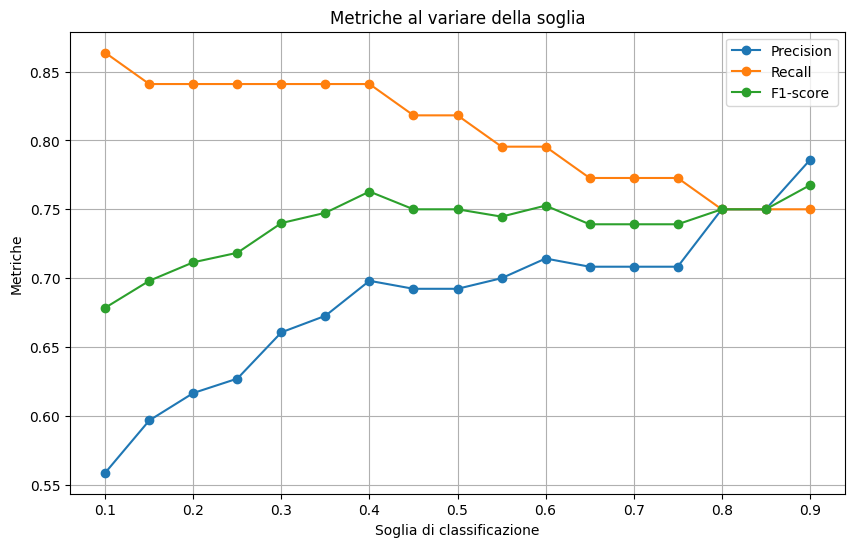

In [36]:
evaluate_thresholds(bert_classifier, all_texts, real_labels)

## Screenshot siti web

### CNN

🧠 Training CNN model on website screenshots...


2025-04-11 14:46:57,862 - src.cnn_model - INFO - Data preparation complete: 1337 training, 286 validation, 287 test samples


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Found 1337 images belonging to 2 classes.
Found 286 images belonging to 2 classes.


Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.5750 - auc: 0.5962 - loss: 0.8802 - val_accuracy: 0.7063 - val_auc: 0.7744 - val_loss: 0.9904 - learning_rate: 5.0000e-04
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.6710 - auc: 0.7219 - loss: 0.7235 - val_accuracy: 0.7098 - val_auc: 0.8248 - val_loss: 0.8001 - learning_rate: 5.0000e-04
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.6884 - auc: 0.7300 - loss: 0.7085 - val_accuracy: 0.7378 - val_auc: 0.8103 - val_loss: 0.8277 - learning_rate: 5.0000e-04
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.6869 - auc: 0.7197 - loss: 0.6626 - val_accuracy: 0.7343 - val_auc: 0.8262 - val_loss: 0.9274 - learning_rate: 5.0000e-04
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.7232 - auc: 0.7751 - loss: 0.6251 - val_accuracy: 0.7657 - val_auc: 0.8252 - val_loss: 0.8159 - learning_rate: 5.0000e-04
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.


CNN Model Evaluation:
Accuracy: 0.7735
AUC: 0.8250

Classification Report:
0: Precision: 0.7987, Recall: 0.7937, F1: 0.7962
1: Precision: 0.7422, Recall: 0.7480, F1: 0.7451
macro avg: Precision: 0.7705, Recall: 0.7709, F1: 0.7707
weighted avg: Precision: 0.7737, Recall: 0.7735, F1: 0.7736

Confusion Matrix:
[[127  33]
 [ 32  95]]

Model saved to: models/cnn\phishing_cnn_model.h5
Training history saved to: models/cnn\training_history.csv


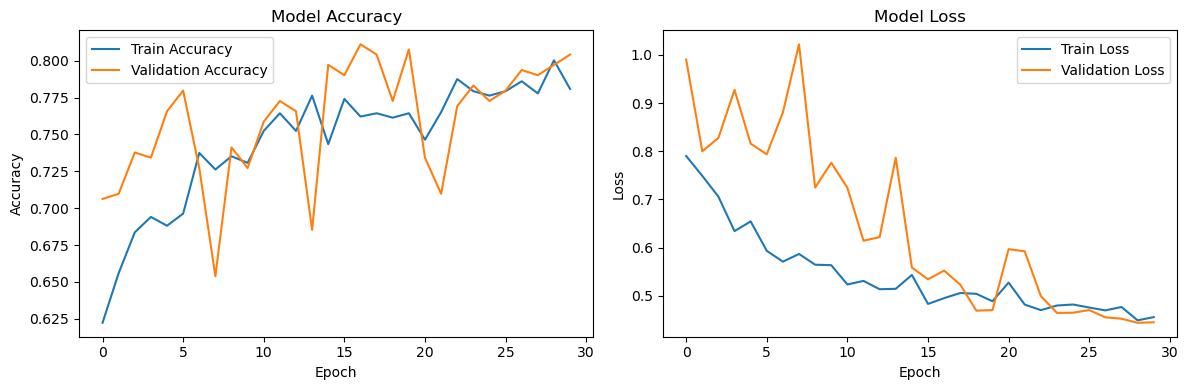

In [ ]:
# Train CNN model on screenshots with optimized parameters
print("🧠 Training CNN model on website screenshots...")
cnn_results = train_cnn_model({
    **config,
    'cnn': {
        'base_model': 'mobilenet',  # Prova MobileNet invece di ResNet50
        'batch_size': 16,  # Batch più piccolo per migliore generalizzazione
        'epochs': 30  # Più epoche
    }
})

# Print CNN results
print("\nCNN Model Evaluation:")
print(f"Accuracy: {cnn_results['evaluation']['accuracy']:.4f}")
print(f"AUC: {cnn_results['evaluation']['auc']:.4f}")
print("\nClassification Report:")
for class_name, metrics in cnn_results['evaluation']['classification_report'].items():
    if isinstance(metrics, dict):
        print(f"{class_name}: Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1: {metrics['f1-score']:.4f}")

print("\nConfusion Matrix:")
print(cnn_results['evaluation']['confusion_matrix'])

print(f"\nModel saved to: {cnn_results['model_path']}")
print(f"Training history saved to: {cnn_results['history_path']}")

### [Modello Huggingface](https://huggingface.co/karolinajocelyn/VIFD2024-ScamClassifier)

In [ ]:
from huggingface_hub import hf_hub_download

# Specifica la cartella di destinazione
model_path = hf_hub_download(
    repo_id="karolinajocelyn/VIFD2024-ScamClassifier",
    filename="yolov8_model.pt",
    local_dir="data\external\models"
)

print("Modello scaricato in:", model_path)

Modello scaricato in: data\external\models\yolov8_model.pt


In [ ]:
from ultralytics import YOLO

# Carica il modello YOLOv8
model = YOLO(model_path)

# Verifica se il modello è stato caricato correttamente
print(model)

..................................................
Modello scaricato correttamente.

In [ ]:
import random

# Definisci il percorso della cartella degli screenshot
screenshots_dir = "data/raw/screenshots"

# Raccogli tutti i percorsi delle immagini con le loro etichette
all_images = []
true_labels = []
predictions = []

for label in ['legit', 'phishing']:
    folder_path = Path(screenshots_dir) / label
    if folder_path.exists():
        images = list(folder_path.glob("*.png"))
        all_images.extend([(img, label) for img in images])

# Mescola casualmente la lista
random.shuffle(all_images)

print("Classi disponibili nel modello:")
print(model.names)

def get_image_score(results):
    """Calcola uno score composito per l'immagine"""
    if not results or len(results) == 0:
        return 0.0

    r = results[0]
    if len(r.boxes) == 0:
        return 0.0

    # Metriche multiple
    num_objects = min(len(r.boxes) / 10, 1.0)  # normalizzato
    avg_conf = sum(float(box.conf[0]) for box in r.boxes) / len(r.boxes)

    # Score basato su tutti gli oggetti rilevati
    class_scores = []
    for box in r.boxes:
        class_name = model.names[int(box.cls[0])]
        conf = float(box.conf[0])
        # Ogni oggetto rilevato contribuisce al punteggio
        class_scores.append(conf)

    class_score = max(class_scores) if class_scores else 0.0

    # Score finale pesato
    return (0.4 * num_objects + 0.3 * avg_conf + 0.3 * class_score)

def classify_image(results, threshold=0.3, min_objects=1):  # Soglia abbassata
    """Classifica usando criteri multipli"""
    if not results or len(results) == 0:
        return 0

    r = results[0]
    # Se ci sono oggetti rilevati con confidence alta, classifica come phishing
    if len(r.boxes) >= min_objects:
        score = get_image_score(results)
        return 1 if score > threshold else 0
    return 0

# 2. Modifica del codice principale
print(f"Analizzando {len(all_images)} immagini totali...")

# Popola true_labels una volta sola prima del loop
true_labels = [1 if label == 'phishing' else 0 for _, label in all_images]

# Test diverse soglie di confidenza
confidence_thresholds = [0.25, 0.5, 0.75, 0.9]
best_accuracy = 0
best_threshold = 0
best_predictions = None

for conf_threshold in confidence_thresholds:
    predictions = []  # Reset predictions per ogni soglia
    print(f"\nTestando soglia di confidenza: {conf_threshold}")

    for img_path, true_label in all_images:
        results = model.predict(
            source=str(img_path),
            conf=conf_threshold,
            save=False
        )

        # Usa la nuova logica di classificazione
        prediction = classify_image(results)
        predictions.append(prediction)

        print(f"\n{img_path.name} (vera: {true_label})")
        if results and len(results) > 0:
            r = results[0]
            score = get_image_score(results)
            print(f"Score: {score:.2f}")
            for box in r.boxes:
                class_id = int(box.cls[0])
                conf = float(box.conf[0])
                class_name = model.names[class_id]
                print(f"- Rilevato: {class_name} (confidenza: {conf:.2f})")

    # Calcola accuracy per questa soglia
    acc = accuracy_score(true_labels, predictions)
    print(f"\nAccuracy con soglia {conf_threshold}: {acc:.4f}")

    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = conf_threshold
        best_predictions = predictions.copy()  # Salva le migliori predizioni

print(f"\nMiglior soglia trovata: {best_threshold} (accuracy: {best_accuracy:.4f}")

# Mostra metriche finali usando le migliori predizioni
print("\n--- Risultati Finali ---")
print("\nClassification Report:")
print(classification_report(true_labels, best_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, best_predictions))

Classi disponibili nel modello:
{0: 'normal', 1: 'scam'}
Analizzando 488 immagini totali...

Testando soglia di confidenza: 0.25

image 1/1 c:\Users\leona\Documents\GitHub\YoroiPhish\data\raw\screenshots\phishing\spotifyinfo.com_008f5513.png: 640x480 1 normal, 544.4ms
Speed: 3.7ms preprocess, 544.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

spotifyinfo.com_008f5513.png (vera: phishing)
Score: 0.62
- Rilevato: normal (confidenza: 0.97)

image 1/1 c:\Users\leona\Documents\GitHub\YoroiPhish\data\raw\screenshots\legit\mamastar.jp_0b49443b.png: 640x480 1 normal, 448.0ms
Speed: 4.3ms preprocess, 448.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

mamastar.jp_0b49443b.png (vera: legit)
Score: 0.61
- Rilevato: normal (confidenza: 0.95)

..................................................

image 1/1 c:\Users\leona\Documents\GitHub\YoroiPhish\data\raw\screenshots\legit\mosyle.com_a7a485e8.png: 640x480 1 normal, 486.4ms
Speed: 49.9ms preprocess, 486.4

# Decision Engine e Fusione dei Risultati

Combiniamo i punteggi provenienti dai modelli per ottenere un punteggio finale e identificare i siti sospetti.

In [10]:
# --- 1. Load Models ---
print("🔄 Loading pre-trained models...")
# Load Random Forest model
rf_model_path = os.path.join('models', 'random_forest.pkl')
rf_model = joblib.load(rf_model_path)
print(f"✅ RF model loaded from {rf_model_path}")

# Load BERT model
bert_model_path = 'models/bert'
bert_classifier = BertPhishingClassifier.from_pretrained(bert_model_path)
print(f"✅ BERT model loaded from {bert_model_path}")

# Load CNN model
cnn_model_path = os.path.join('models', 'cnn', 'phishing_cnn_model.h5')
cnn_model = tf.keras.models.load_model(cnn_model_path)
print(f"✅ CNN model loaded from {cnn_model_path}")

# --- 2. Load Test Data ---
print("\n🔄 Loading test data...")

# Load reference test data to get hash_id based on order
reference_test_path = os.path.join(config["paths"]["results"], "test.csv")
try:
    reference_df = pd.read_csv(reference_test_path)
    # Extract hash_id from html_file (e.g., 'data/raw/test/domain.com_hash123.html' -> 'hash123')
    # Handle potential errors if the format is unexpected
    reference_hash_ids = reference_df['html_file'].apply(
        lambda x: Path(x).stem.split('_')[-1] if isinstance(x, str) and '_' in Path(x).stem else None
    ).tolist()
    print(f"✅ Loaded reference test data from {reference_test_path} to extract hash_ids.")
except FileNotFoundError:
    print(f"❌ Error: Reference file {reference_test_path} not found. Cannot extract hash_ids.")
    reference_hash_ids = None
except KeyError:
    print(f"❌ Error: 'html_file' column not found in {reference_test_path}. Cannot extract hash_ids.")
    reference_hash_ids = None
except Exception as e:
    print(f"❌ Error processing {reference_test_path}: {e}")
    reference_hash_ids = None

# RF Test Data (Load features and add hash_id)
rf_test_data_path = os.path.join(config["paths"]["trainingdata"], "test_features.csv")
rf_test_df = pd.read_csv(rf_test_data_path)

if reference_hash_ids is not None:
    if len(rf_test_df) == len(reference_hash_ids):
        rf_test_df['hash_id'] = reference_hash_ids
        print(f"✅ Added 'hash_id' column to RF test data based on order in {reference_test_path}.")

        # Now extract features, labels, and hash_ids
        # Ensure 'is_phishing' column exists in test_features.csv
        if 'is_phishing' not in rf_test_df.columns:
             print("⚠️ Warning: 'is_phishing' column not found in test_features.csv. Using default or placeholder.")
             # Option 1: Try to get it from reference_df if columns match
             if 'is_phishing' in reference_df.columns and len(reference_df) == len(rf_test_df):
                 rf_test_df['is_phishing'] = reference_df['is_phishing']
                 print("✅ Added 'is_phishing' from reference_df.")
             else:
                 # Option 2: Add a placeholder if needed for structure, but evaluation will be incorrect
                 rf_test_df['is_phishing'] = 0 # Placeholder, evaluation will be wrong!
                 print("❌ Added placeholder 'is_phishing'. Evaluation results for RF will be incorrect.")

        X_test_rf = rf_test_df.drop(['is_phishing', 'hash_id'], axis=1, errors='ignore')
        y_true_rf = rf_test_df['is_phishing']
        rf_hash_ids = rf_test_df['hash_id']

    else:
        print(f"❌ Error: Mismatch in number of records between {rf_test_data_path} ({len(rf_test_df)}) and {reference_test_path} ({len(reference_hash_ids)}). Cannot reliably add hash_id.")
        # Handle error: maybe stop execution or proceed without hash_id for RF
        X_test_rf = rf_test_df.drop(['is_phishing'], axis=1, errors='ignore') # Drop only is_phishing if hash_id wasn't added
        y_true_rf = rf_test_df['is_phishing'] if 'is_phishing' in rf_test_df.columns else pd.Series([0]*len(rf_test_df)) # Placeholder
        rf_hash_ids = pd.Series([None]*len(rf_test_df)) # No valid hash_ids
else:
     print(f"❌ Skipping RF hash_id addition due to previous errors.")
     X_test_rf = rf_test_df.drop(['is_phishing'], axis=1, errors='ignore')
     y_true_rf = rf_test_df['is_phishing'] if 'is_phishing' in rf_test_df.columns else pd.Series([0]*len(rf_test_df)) # Placeholder
     rf_hash_ids = pd.Series([None]*len(rf_test_df)) # No valid hash_ids

# BERT Test Data
bert_test_data_path = os.path.join(config["paths"]["results"], "hash_id&text_for_bert.csv")
bert_test_df_raw = pd.read_csv(bert_test_data_path)
bert_test_df = bert_test_df_raw.copy()
bert_texts = bert_test_df['text'].tolist()
y_true_bert = bert_test_df['is_phishing'].tolist()
bert_hash_ids = bert_test_df['hash_id'] # Make sure this column exists

# CNN Test Data (Paths and Labels)
cnn_test_data_path = os.path.join(config["paths"]["test_screenshots_results"])
cnn_test_df = pd.read_csv(cnn_test_data_path)
cnn_image_paths = cnn_test_df['screenshot_path'].tolist()
y_true_cnn = cnn_test_df['is_phishing'].tolist()
cnn_hash_ids = cnn_test_df['hash_id'].tolist() # Make sure this column exists

# --- 3. Get Probabilities ---
print("\n🔄 Generating predictions (probabilities)...")

# RF Predictions
rf_probs = rf_model.predict_proba(X_test_rf)[:, 1]
rf_results = pd.DataFrame({'hash_id': rf_hash_ids, 'rf_prob': rf_probs, 'is_phishing_rf': y_true_rf})
print(f"✅ RF predictions generated for {len(rf_results)} samples.")

# BERT Predictions
bert_results_dict = bert_classifier.predict(bert_texts)
bert_probs = bert_results_dict['phishing_probability']
bert_results = pd.DataFrame({'hash_id': bert_hash_ids, 'bert_prob': bert_probs, 'is_phishing_bert': y_true_bert})
print(f"✅ BERT predictions generated for {len(bert_results)} samples.")

# CNN Predictions (Requires image loading and preprocessing)
# This part is more involved as it requires processing images.
# You'll need a function to load, resize (to model's expected input, e.g., 224x224), and rescale images.
def preprocess_image(img_path, target_size=(224, 224)):
    try:
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Create batch axis
        img_array = img_array / 255.0 # Rescale
        return img_array
    except Exception as e:
        print(f"⚠️ Error processing image {img_path}: {e}")
        return None

cnn_probs_list = []
valid_cnn_hash_ids = []
valid_y_true_cnn = []

print(f"⏳ Generating CNN predictions for {len(cnn_image_paths)} images (this may take time)...")
for i, img_path in enumerate(cnn_image_paths):
    processed_img = preprocess_image(img_path)
    if processed_img is not None:
        prob = cnn_model.predict(processed_img, verbose=0)[0][0] # Get probability for the single image
        cnn_probs_list.append(prob)
        valid_cnn_hash_ids.append(cnn_hash_ids[i])
        valid_y_true_cnn.append(y_true_cnn[i])
    # else: Add handling for images that failed processing if needed

cnn_results = pd.DataFrame({'hash_id': valid_cnn_hash_ids, 'cnn_prob': cnn_probs_list, 'is_phishing_cnn': valid_y_true_cnn})
print(f"✅ CNN predictions generated for {len(cnn_results)} valid images.")


# --- 4. Combine Probabilities ---
print("\n🔄 Combining model probabilities...")
# Merge results based on hash_id
# rf_results includes: 'hash_id', 'rf_prob', 'is_phishing_rf'
# bert_results includes: 'hash_id', 'bert_prob', 'is_phishing_bert'
# cnn_results includes: 'hash_id', 'cnn_prob', 'is_phishing_cnn'

# Merge all results using outer join to keep all hash_ids
ensemble_df = rf_results.merge(bert_results, on='hash_id', how='outer')
ensemble_df = ensemble_df.merge(cnn_results, on='hash_id', how='outer')

# Consolidate the 'is_phishing' label.
# We assume that for a given hash_id, the 'is_phishing' label is consistent
# if it appears in multiple source dataframes. We'll take the first non-null one.
# Start with rf's label, then fill NaNs with bert's, then cnn's.
if 'is_phishing_rf' in ensemble_df.columns:
    ensemble_df['is_phishing'] = ensemble_df['is_phishing_rf']
    if 'is_phishing_bert' in ensemble_df.columns:
        ensemble_df['is_phishing'].fillna(ensemble_df['is_phishing_bert'], inplace=True)
    if 'is_phishing_cnn' in ensemble_df.columns:
        ensemble_df['is_phishing'].fillna(ensemble_df['is_phishing_cnn'], inplace=True)
elif 'is_phishing_bert' in ensemble_df.columns: # If RF label column was missing
    ensemble_df['is_phishing'] = ensemble_df['is_phishing_bert']
    if 'is_phishing_cnn' in ensemble_df.columns:
        ensemble_df['is_phishing'].fillna(ensemble_df['is_phishing_cnn'], inplace=True)
elif 'is_phishing_cnn' in ensemble_df.columns: # If RF and BERT label columns were missing
    ensemble_df['is_phishing'] = ensemble_df['is_phishing_cnn']
else:
    # Fallback if no is_phishing columns were found (should not happen with correct inputs)
    ensemble_df['is_phishing'] = np.nan 

# Drop the original individual is_phishing columns now that we have a consolidated one
cols_to_drop = [col for col in ['is_phishing_rf', 'is_phishing_bert', 'is_phishing_cnn'] if col in ensemble_df.columns]
ensemble_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print(f"✅ Combined results for {len(ensemble_df)} unique hash_ids. Some may have missing model scores or labels.")

# --- 5. Ensemble Calculation & Evaluation ---
print("\n🔄 Evaluating simple averaging ensemble...")

# Simple Averaging - .mean(axis=1) handles NaNs by default (ignores them in the sum/count)
prob_cols = ['rf_prob', 'bert_prob', 'cnn_prob']
# Ensure all probability columns exist before trying to average
existing_prob_cols = [col for col in prob_cols if col in ensemble_df.columns]
if existing_prob_cols:
    ensemble_df['avg_prob'] = ensemble_df[existing_prob_cols].mean(axis=1)
else:
    ensemble_df['avg_prob'] = np.nan # No probability columns found


# --- START: Custom Ensemble Logic with Specific Rules ---
# Initialize 'ensemble_pred' based on the average probability threshold.
# This is the baseline prediction.
# If avg_prob is NaN, .fillna(0) ensures it's treated as 0 for this initial thresholding,
# leading to an initial prediction of 0 (legitimate) if avg_prob is NaN.
current_avg_threshold = 0.6
ensemble_df['ensemble_pred'] = (ensemble_df.get('avg_prob', pd.Series(np.nan, index=ensemble_df.index)).fillna(0) >= current_avg_threshold).astype(int)

# For rule evaluation, we directly use the original probability columns from ensemble_df,
# which may contain NaNs. The rules will explicitly check for .notna().

# Rule 1: RF > 0.8 -> phishing (only if RF score is present)
# Use .get() to safely access columns, providing a default Series of NaNs if the column doesn't exist.
rf_prob_original = ensemble_df.get('rf_prob', pd.Series(np.nan, index=ensemble_df.index))
rule1_condition = rf_prob_original.notna() & (rf_prob_original > 0.8)

# Rule 2: CNN > 0.99 & RF > 0.5 -> phishing (only if both scores are present)
cnn_prob_original = ensemble_df.get('cnn_prob', pd.Series(np.nan, index=ensemble_df.index))
# rf_prob_original is already defined from Rule 1
rule2_condition = (cnn_prob_original.notna() & (cnn_prob_original > 0.99) &
                    rf_prob_original.notna() & (rf_prob_original > 0.5))

# Rule 3: BERT > 0.99 & RF > 0.5 -> phishing (only if both scores are present)
bert_prob_original = ensemble_df.get('bert_prob', pd.Series(np.nan, index=ensemble_df.index))
# rf_prob_original is already defined from Rule 1
rule3_condition = (bert_prob_original.notna() & (bert_prob_original > 0.99) &
                    rf_prob_original.notna() & (rf_prob_original > 0.5))

# Apply rules: if any rule condition is met, set ensemble_pred to 1 (phishing).
# These rules act as overrides, potentially changing an initial prediction of 0 (legitimate) to 1 (phishing).
ensemble_df.loc[rule1_condition, 'ensemble_pred'] = 1
ensemble_df.loc[rule2_condition, 'ensemble_pred'] = 1
ensemble_df.loc[rule3_condition, 'ensemble_pred'] = 1
# --- END: Custom Ensemble Logic with Specific Rules ---


# Filter for evaluation: only rows with a non-NaN ground truth label AND a non-NaN average probability
eval_df = ensemble_df.dropna(subset=['is_phishing', 'avg_prob']).copy()

if not eval_df.empty:
    y_true_ensemble = eval_df['is_phishing'].astype(int) # Ensure it's int for metrics
    y_pred_ensemble = eval_df['ensemble_pred']

    accuracy = accuracy_score(y_true_ensemble, y_pred_ensemble)
    # Add zero_division=0 to handle cases where a class might not be present in predictions or true labels for small eval sets
    report = classification_report(y_true_ensemble, y_pred_ensemble, zero_division=0)
    conf_matrix = confusion_matrix(y_true_ensemble, y_pred_ensemble)

    print(f"\n--- Ensemble Results (Simple Averaging on {len(eval_df)} evaluable samples) ---")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(conf_matrix)
else:
    print("\n--- Ensemble Results (Simple Averaging) ---")
    print("⚠️ No evaluable samples found after combining results (all rows had missing ground truth 'is_phishing' or missing all model scores).")

# Display some combined results (shows all rows, including those not in eval_df)
print("\nSample Ensemble Results (includes rows with potential NaNs):")
display_cols_options = ['hash_id', 'is_phishing', 'rf_prob', 'bert_prob', 'cnn_prob', 'avg_prob', 'ensemble_pred']
# Ensure all display_cols exist before trying to print
actual_display_cols = [col for col in display_cols_options if col in ensemble_df.columns]
if actual_display_cols:
    print(ensemble_df[actual_display_cols].head())
else:
    print("⚠️ No columns available for display in ensemble_df sample.")


# --- Salva CSV con probabilità per modello, ground truth e predizione ensemble ---",
output_csv_predictions_path = os.path.join(config["paths"]["results"], "model_predictions_comparison.csv")
columns_to_save = ['hash_id', 'is_phishing', 'rf_prob', 'bert_prob', 'cnn_prob', 'avg_prob', 'ensemble_pred']
existing_columns_to_save = [col for col in columns_to_save if col in ensemble_df.columns]

# Verifica che le colonne fondamentali (hash_id, is_phishing) e almeno una probabilità di modello siano presenti",
essential_cols_present = 'hash_id' in existing_columns_to_save and 'is_phishing' in existing_columns_to_save and any(p_col in existing_columns_to_save for p_col in ['rf_prob', 'bert_prob', 'cnn_prob', 'avg_prob'])

if essential_cols_present:
    ensemble_df[existing_columns_to_save].to_csv(output_csv_predictions_path, index=False)
    print(f"\n💾 CSV con probabilità per modello, ground truth e predizione ensemble salvato in: {output_csv_predictions_path}")
    print(f"   Colonne salvate: {existing_columns_to_save}")
else:
    print(f"\n⚠️ Non è stato possibile salvare il CSV delle predizioni. Colonne essenziali mancanti o nessuna colonna di probabilità trovata.")
    print(f"   Colonne richieste (almeno hash_id, is_phishing, e una probabilità): {columns_to_save}")
    print(f"   Colonne trovate in ensemble_df: {ensemble_df.columns.tolist()}")
    print(f"   Colonne effettivamente selezionate per il salvataggio (se la logica lo permettesse): {existing_columns_to_save}")

🔄 Loading pre-trained models...
✅ RF model loaded from models\random_forest.pkl
✅ BERT model loaded from models/bert


2025-05-09 12:22:52,305 - 2025-05-09 12:22:52,305 - Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


✅ CNN model loaded from models\cnn\phishing_cnn_model.h5

🔄 Loading test data...
✅ Loaded reference test data from data/results/test.csv to extract hash_ids.
✅ Added 'hash_id' column to RF test data based on order in data/results/test.csv.

🔄 Generating predictions (probabilities)...
✅ RF predictions generated for 189 samples.
✅ BERT predictions generated for 189 samples.
⏳ Generating CNN predictions for 152 images (this may take time)...
✅ CNN predictions generated for 152 valid images.

🔄 Combining model probabilities...


C:\Users\lalberti\AppData\Local\Temp\ipykernel_14024\594728541.py:158: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ensemble_df['is_phishing'].fillna(ensemble_df['is_phishing_bert'], inplace=True)
C:\Users\lalberti\AppData\Local\Temp\ipykernel_14024\594728541.py:160: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

✅ Combined results for 189 unique hash_ids. Some may have missing model scores or labels.

🔄 Evaluating simple averaging ensemble...

--- Ensemble Results (Simple Averaging on 189 evaluable samples) ---
Accuracy: 0.9365

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       145
           1       0.88      0.84      0.86        44

    accuracy                           0.94       189
   macro avg       0.92      0.90      0.91       189
weighted avg       0.94      0.94      0.94       189


Confusion Matrix:
[[140   5]
 [  7  37]]

Sample Ensemble Results (includes rows with potential NaNs):
    hash_id  is_phishing  rf_prob  bert_prob  cnn_prob  avg_prob  \
0  04ddf829            0     0.07   0.007630  0.005103  0.027578   
1  054689c6            0     0.07   0.003149  0.006146  0.026432   
2  05fd1def            0     0.31   0.284057  0.014715  0.202924   
3  06b63602            0     0.08   0.002938  0.00374

## Risultati

### Studio thresholds

**Threshold: 0.4**

--- Ensemble Results (Simple Averaging on 189 evaluable samples) ---  
Accuracy: 0.8730  

Classification Report:  
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       145
           1       0.68      0.86      0.76        44

       accuracy                        0.87       189
    macro avg      0.82      0.87      0.84       189
    weighted avg   0.89      0.87      0.88       189


Confusion Matrix:  
[[127  18]  
 [  6  38]]


**Threshold: 0.5**

--- Ensemble Results (Simple Averaging on 189 evaluable samples) ---  
Accuracy: 0.9048  

Classification Report:  
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       145
           1       0.78      0.82      0.80        44

       accuracy                        0.90       189
    macro avg      0.86      0.87      0.87       189
    weighted avg   0.91      0.90      0.91       189


Confusion Matrix:  
[[135  10]  
 [  8  36]]


**Threshold: 0.5 e Rule 1: RF > 0.8 -> phishing, Rule 2: CNN > 0.99 & RF > 0.5 -> phishing, Rule 3: BERT > 0.99 & RF > 0.5 -> phishing**

--- Ensemble Results (Simple Averaging on 189 evaluable samples) ---  
Accuracy: 0.9101  

Classification Report:  
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       145
           1       0.79      0.84      0.81        44

         accuracy                      0.91       189
     macro avg     0.87      0.89      0.88       189
     weighted avg  0.91      0.91      0.91       189


Confusion Matrix:  
[[135  10]  
 [  7  37]]


**Threshold: 0.6**

--- Ensemble Results (Simple Averaging on 189 evaluable samples) ---  
Accuracy: 0.9101  

Classification Report:  
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       145
           1       0.86      0.73      0.79        44

       accuracy                        0.91       189
    macro avg      0.89      0.85      0.87       189
    weighted avg   0.91      0.91      0.91       189


Confusion Matrix:  
[[140   5]  
 [ 12  32]]
  
  
#### **Migliore**
**Threshold: 0.6 e Rule 1: RF > 0.8 -> phishing, Rule 2: CNN > 0.99 & RF > 0.5 -> phishing, Rule 3: BERT > 0.99 & RF > 0.5 -> phishing**

--- Ensemble Results (Simple Averaging on 189 evaluable samples) ---  
Accuracy: 0.9365  

Classification Report:  
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       145
           1       0.88      0.84      0.86        44

         accuracy                      0.94       189
     macro avg     0.92      0.90      0.91       189
     weighted avg  0.94      0.94      0.94       189


Confusion Matrix:  
[[140   5]  
 [  7  37]]
  
  
**Threshold: 0.7 e Rule 1: RF > 0.8 -> phishing, Rule 2: CNN > 0.99 & RF > 0.5 -> phishing, Rule 3: BERT > 0.99 & RF > 0.5 -> phishing**

--- Ensemble Results (Simple Averaging on 189 evaluable samples) ---  
Accuracy: 0.9259  

Classification Report:  
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       145
           1       0.89      0.77      0.83        44

         accuracy                      0.93       189
     macro avg     0.91      0.87      0.89       189
     weighted avg  0.92      0.93      0.92       189


Confusion Matrix:  
[[141   4]  
 [ 10  34]]

### Rows interessanti (td 0.6 -> td 0.6 + rules)
```
i       hash_id      is_phi.     rf        bert             cnn               avg        ensemble_pred      ensemble_pred_rules

26	2462c8f0	1	0.72	0.028778216	0.0028682647	0.2505488268503298	0
34	31361a87	0	0.3	0.99810636	None	        0.6490531802177429	1
35	3150bf5f	0	0.37	0.03474269	0.9973136	0.4673521030942599	0
36	315296fc	1	0.43	0.9984989	None	        0.7142494583129883	1
64	544873d0	0	0.77	0.78844875	0.021411328	0.5266200262059768	0
116	a2e4a11a	1	0.51	0.99818015	0.00043934697	0.5028731659858022	0                     1
117	a4500196	1	0.19	0.11819464	0.0006738415	0.1029561603977344	0
125	aab9e624	1	0.2	0.036525954	None	        0.1182629767805338	0
130	af188ff6	1	0.57	0.06093236	0.99847776	0.5431367058555284	0                     1
131	b01b6024	1	0.45	0.9183764	0.008385729	0.4589207050700982	0
132	b3c74830	0	0.65	0.014995699	0.0059513436	0.2236490141289929	0
133	b435f760	1	0.66	0.9982175	0.09480683	0.5843414502342542	0                     1
146	c8f1ee1a	1	0.59	0.9939738	0.0036499838	0.5292079251290609	0                     1
156	d21f978f	1	0.27	0.44653642	None	        0.3582682108879089	0
157	d4206e0d	1	0.82	0.0065469183	0.6715771	0.4993746714293956	0                     1
158	d49dee77	1	0.38	0.0072189686	None	        0.1936094842944294	0
167	e4c8d707	1	0.63	0.99021727	None	        0.8101086342334747	1
176	f29e9019	0	0.8	0.9967121	0.99784434	0.931518809000651	1
179	f82523bb	1	0.57	0.9983261	0.44508922	0.6711384479204813	1
187	ff77f48f	1	0.69	0.5219065	None	        0.6059532475471496	1
```
siti di phishing che tutte (o RF e BERT con CNN nulla) fanno fatica a riconoscere:  
117: [se-connecter.net_a4500196](data\raw\screenshots\test_phishing\se-connecter.net_a4500196.png)  
125: [cutt.ly_aab9e624](data\raw\test\cutt.ly_aab9e624.html)  
156: [micro-sales.co.uk_d21f978f](data\raw\test\micro-sales.co.uk_d21f978f.html)  
158: [shop.hostingdude.com_d49dee77](data\raw\test\shop.hostingdude.com_d49dee77.html)  

siti legittimi che tutte (o RF e BERT con CNN nulla) fanno fatica a riconoscere:  
176: [www.hangthebankers.com_f29e9019](data\raw\screenshots\test_legit\www.hangthebankers.com_f29e9019.png)  



1.  **Logica Decisionale a Livelli (Tiered Decision Logic):**
    *   **Idea:** Se RF è molto sicuro (es. < 0.3 per legit, > 0.75 per phishing), la sua predizione ha la precedenza. Altrimenti, si valuta BERT e/o CNN.
    *   **Nei dati:**
        *   **Riga 26** (`is_phi=1`): RF=0.72 (phishing), ma BERT e CNN sono bassissimi (<0.03). L'ensemble predice 0 (legit). Qui, una regola "RF > 0.7 -> phishing" verrebbe contraddetta dagli altri.
        *   **Riga 34** (`is_phi=0`): RF=0.3 (legit), ma BERT=0.998 (phishing). L'ensemble predice 1 (phishing). Qui, "RF < 0.3 -> legit" sarebbe corretto, ma BERT è fortemente discorde. La logica a livelli dovrebbe gestire questa forte discordanza.
        *   **Riga 132** (`is_phi=0`): RF=0.65 (phishing), BERT e CNN bassissimi. L'ensemble predice 0 (corretto). Qui la media ha funzionato bene nonostante un RF moderatamente alto.

2.  **Gestione di Forti Disaccordi:**
    *   **Idea:** Se un modello è moderatamente convinto in una direzione e un altro è fortemente convinto nella direzione opposta, si stabilisce quale modello ha la precedenza.
    *   **Nei dati:**
        *   **Riga 157** (`is_phi=1`): RF=0.82 (phishing forte), BERT=0.006 (legit forte), CNN=0.671 (phishing moderato). L'ensemble predice 0. Qui RF e CNN spingono per phishing, ma il BERT bassissimo abbassa la media. Un forte disaccordo tra RF e BERT.
        *   **Riga 64** (`is_phi=0`): RF=0.77 (phishing), BERT=0.788 (phishing), ma CNN=0.021 (legit forte). L'ensemble predice 0 (corretto). La CNN, fortemente discorde, ha "salvato" la predizione.
    
    **Soluzione:** "RF > 0.8 -> phishing"

3.  **Punti di Forza Specifici dei Modelli:**
    *   **Idea:** Se si sa che un modello è particolarmente bravo in certi scenari (es. CNN per l'aspetto visivo), il suo output può avere un peso maggiore in quei casi.
    *   **Nei dati:**
        *   **Riga 130** (`is_phi=1`): RF=0.57, BERT=0.06, ma CNN=0.998 (phishing fortissimo). L'ensemble predice 0. Se la CNN fosse considerata molto affidabile per certi tipi di phishing visivo, il suo punteggio alto potrebbe sovrascrivere gli altri o pesare molto di più, portando a una predizione corretta di phishing.
        *   **Riga 35** (`is_phi=0`): RF=0.37, BERT=0.034, CNN=0.997. L'ensemble predice 0 (corretto). Qui la CNN è alta ma il sito è legittimo. Questo mostra che la regola non può essere assoluta.
    
    **Soluzione:** "se CNN > 0.99 & RF > 0.5 -> phishing"

4.  **Aggiustamenti per Output Mancanti (`None`):**
    *   **Idea:** Quando un modello (es. CNN) non fornisce un output, si modifica la logica di ensemble (es. si dà più peso ai modelli rimanenti o si cambiano le soglie).
    *   **Nei dati:**
        *   **Riga 36** (`is_phi=1`): RF=0.43, BERT=0.998, CNN=`None`. L'ensemble predice 1 (corretto). Qui la media tra RF e BERT ha funzionato.
        *   **Riga 125** (`is_phi=1`): RF=0.2, BERT=0.036, CNN=`None`. L'ensemble predice 0. Questo è un caso difficile dove i modelli disponibili danno punteggi bassi per un sito di phishing.
        *   Molte righe hanno CNN=`None`. L'attuale media semplice gestisce questo ignorando i `None`. Una strategia più avanzata potrebbe essere: "Se CNN è `None` e BERT > 0.9, classifica come phishing anche se RF è basso/medio". (Vedi riga 36).

5.  **Accordo Minimo o "Punteggio di Sospetto":**
    *   **Idea:** Richiedere che almeno due modelli tendano verso il phishing, oppure se un singolo modello è estremamente alto, questo potrebbe essere sufficiente.
    *   **Nei dati:**
        *   **Riga 133** (`is_phi=1`): RF=0.66, BERT=0.998 (entrambi phishing), CNN=0.094 (legit). L'avg è 0.584, quindi l'ensemble predice 0 (sbagliato, con soglia 0.6). Qui due modelli concordano sul phishing. Una regola "se RF > 0.6 E BERT > 0.6 -> phishing" potrebbe aiutare.
        *   **Riga 116** (`is_phi=1`): RF=0.51, BERT=0.998, CNN=0.0004. Avg=0.502, ensemble_pred=0. BERT è altissimo, ma gli altri due sono bassi. Se un BERT > 0.95 fosse un forte indicatore, potrebbe avere più peso.
    
    **Soluzione:** "se BERT > 0.99 & RF > 0.5 -> phishing"

Questi esempi mostrano come le strategie generali possono essere applicate per affrontare i pattern e gli errori specifici osservati nei dati. L'obiettivo è rendere l'ensemble più intelligente della semplice media, specialmente nei casi ambigui o quando i modelli sono in forte disaccordo.

## Studio dei pesi
studio approfondito sui pesi di ciascun modello per capire se ci sono possibili miglioramenti.

In [ ]:
# --- Inizio Codice Modificato per la Ricerca dei Pesi ---

print("\n🔄 Inizio ricerca delle migliori combinazioni di pesi...")

# Definisci i possibili valori per i pesi (da 0.0 a 1.0 con passo 0.1)
# Puoi cambiare il passo per una ricerca più fine (es. 0.05) o più grossolana (es. 0.2)
# Un passo più piccolo aumenta significativamente il numero di combinazioni.
weight_step = 0.1  # Esempio: passo 0.2 per ridurre il numero di combinazioni per il test
# weight_step = 0.1 # Per una ricerca più completa (1331 combinazioni)
possible_individual_weights = np.round(np.arange(0.0, 1.0 + weight_step, weight_step), 2)

# Genera tutte le combinazioni di pesi per i 3 modelli
# Filtra le combinazioni in cui tutti i pesi sono 0, poiché non sono informative
weight_combinations = [
    combo for combo in itertools.product(possible_individual_weights, repeat=3)
    if not all(w == 0 for w in combo)
]

print(f"🔍 Verranno testate {len(weight_combinations)} combinazioni di pesi.")

all_ensemble_results = []

# Colonne delle probabilità dei modelli
prob_cols_map = {'rf': 'rf_prob', 'bert': 'bert_prob', 'cnn': 'cnn_prob'}

# Assicurati che eval_df e y_true_ensemble siano definiti dalla cella precedente
# y_true_ensemble è la base per la valutazione
if 'eval_df' not in locals() or eval_df.empty:
    print("⚠️ eval_df non è definito o è vuoto. Impossibile procedere con la ricerca dei pesi.")
    print("   Assicurati di aver eseguito la cella precedente che calcola 'avg_prob' e definisce 'eval_df'.")
else:
    y_true_for_evaluation = eval_df['is_phishing'].astype(int) # Usato per tutte le valutazioni

    for i, (w_rf, w_bert, w_cnn) in enumerate(weight_combinations):
        current_weights = {'rf': w_rf, 'bert': w_bert, 'cnn': w_cnn}
        
        if (i + 1) % 100 == 0: # Stampa un aggiornamento ogni 100 combinazioni
            print(f"  Progresso: {i+1}/{len(weight_combinations)} combinazioni testate...")

        # Inizializza il numeratore e il denominatore per la media pesata
        numerator = pd.Series(0.0, index=ensemble_df.index)
        denominator_sum_weights = pd.Series(0.0, index=ensemble_df.index)

        for model_key, weight_val in current_weights.items():
            prob_col_name = prob_cols_map.get(model_key)
            if prob_col_name and prob_col_name in ensemble_df.columns:
                is_valid_prob = ensemble_df[prob_col_name].notna()
                numerator += ensemble_df[prob_col_name].fillna(0) * weight_val * is_valid_prob
                denominator_sum_weights += weight_val * is_valid_prob
        
        # Calcola la media pesata corretta
        # ensemble_df['weighted_prob_iter'] = numerator / denominator_sum_weights.replace(0, np.nan)
        # Per evitare di aggiungere troppe colonne a ensemble_df in loop, calcoliamo le prob solo per eval_df
        
        # Calcoliamo weighted_prob specificamente per le righe in eval_df per efficienza
        # e per assicurarci di usare gli stessi indici di y_true_for_evaluation
        numerator_eval = pd.Series(0.0, index=eval_df.index)
        denominator_sum_weights_eval = pd.Series(0.0, index=eval_df.index)

        for model_key, weight_val in current_weights.items():
            prob_col_name = prob_cols_map.get(model_key)
            if prob_col_name and prob_col_name in eval_df.columns: # Usa eval_df qui
                is_valid_prob_eval = eval_df[prob_col_name].notna()
                numerator_eval += eval_df[prob_col_name].fillna(0) * weight_val * is_valid_prob_eval
                denominator_sum_weights_eval += weight_val * is_valid_prob_eval
        
        weighted_prob_eval = numerator_eval / denominator_sum_weights_eval.replace(0, np.nan)

        # Calcola la predizione basata sulla soglia (es. 0.5 o quella che preferisci)
        current_weighted_threshold = 0.5 # Mantieni la soglia costante o variala se necessario
        # y_pred_weighted_eval = (ensemble_df.loc[y_true_for_evaluation.index, 'weighted_prob_iter'].fillna(0) >= current_weighted_threshold).astype(int)
        y_pred_weighted_eval = (weighted_prob_eval.fillna(0) >= current_weighted_threshold).astype(int)
        
        # Calcola le metriche
        accuracy = accuracy_score(y_true_for_evaluation, y_pred_weighted_eval)
        cm = confusion_matrix(y_true_for_evaluation, y_pred_weighted_eval)
        # report = classification_report(y_true_for_evaluation, y_pred_weighted_eval, zero_division=0, output_dict=True)
        
        all_ensemble_results.append({
            'weights': current_weights,
            'accuracy': accuracy,
            'confusion_matrix': cm,
            # 'f1_phishing': report.get('1', {}).get('f1-score', 0.0) # Esempio per F1-score phishing
        })

    if all_ensemble_results:
        # Ordina i risultati per accuratezza (decrescente)
        # Puoi cambiare 'accuracy' con 'f1_phishing' se preferisci ottimizzare per F1-score
        sorted_results = sorted(all_ensemble_results, key=lambda x: x['accuracy'], reverse=True)
        
        print("\n🏆 Top 10 Migliori Combinazioni di Pesi (ordinate per Accuratezza):")
        for i, res in enumerate(sorted_results[:50]):
            print(f"\n{i+1}. Accuratezza: {res['accuracy']:.4f}")
            print(f"   Pesi: {res['weights']}")
            print(f"   Matrice di Confusione:\n{res['confusion_matrix']}")
    else:
        print("⚠️ Nessun risultato di ensemble calcolato.")

print("\n✅ Ricerca dei pesi completata.")
# --- Fine Codice Modificato ---


🔄 Inizio ricerca delle migliori combinazioni di pesi...
🔍 Verranno testate 1330 combinazioni di pesi.
  Progresso: 100/1330 combinazioni testate...
  Progresso: 200/1330 combinazioni testate...
  Progresso: 300/1330 combinazioni testate...
  Progresso: 400/1330 combinazioni testate...
  Progresso: 500/1330 combinazioni testate...
  Progresso: 600/1330 combinazioni testate...
  Progresso: 700/1330 combinazioni testate...
  Progresso: 800/1330 combinazioni testate...
  Progresso: 900/1330 combinazioni testate...
  Progresso: 1000/1330 combinazioni testate...
  Progresso: 1100/1330 combinazioni testate...
  Progresso: 1200/1330 combinazioni testate...
  Progresso: 1300/1330 combinazioni testate...

🏆 Top 10 Migliori Combinazioni di Pesi (ordinate per Accuratezza):

1. Accuratezza: 0.9259
   Pesi: {'rf': 0.3, 'bert': 0.1, 'cnn': 0.1}
   Matrice di Confusione:
[[138   7]
 [  7  37]]

2. Accuratezza: 0.9259
   Pesi: {'rf': 0.5, 'bert': 0.2, 'cnn': 0.2}
   Matrice di Confusione:
[[138   7]
 

## Salvataggio del modello dell'ensemble

In [5]:
# Definisci i parametri dell'ensemble basati sulla tua analisi
# (Threshold: 0.6 e Rule 1: RF > 0.8, Rule 2: CNN > 0.99 & RF > 0.5, Rule 3: BERT > 0.99 & RF > 0.5)
ensemble_config = {
    "description": "Configurazione del modello ensemble con soglia media e regole di override.",
    "model_paths": {
        "rf": os.path.join('models', 'random_forest.pkl'),
        "bert": os.path.join('models', 'bert'),
        "cnn": os.path.join('models', 'cnn', 'phishing_cnn_model.h5')
    },
    "ensemble_parameters": {
        "avg_prediction_threshold": 0.6,
        "rules": {
            "rf_direct_phishing": {
                "condition": "rf_prob > threshold",
                "rf_threshold": 0.8
            },
            "cnn_rf_phishing": {
                "condition": "cnn_prob > cnn_threshold AND rf_prob > rf_threshold",
                "cnn_threshold": 0.99,
                "rf_threshold": 0.5
            },
            "bert_rf_phishing": {
                "condition": "bert_prob > bert_threshold AND rf_prob > rf_threshold",
                "bert_threshold": 0.99,
                "rf_threshold": 0.5
            }
        }
    }
}

# Percorso per salvare la configurazione dell'ensemble
ensemble_dir = os.path.join('models', 'ensemble')
os.makedirs(ensemble_dir, exist_ok=True) # Crea la cartella se non esiste
config_save_path = os.path.join(ensemble_dir, 'ensemble_model_config.json')

# Salva la configurazione in un file JSON
try:
    with open(config_save_path, 'w') as f:
        json.dump(ensemble_config, f, indent=4)
    print(f"✅ Configurazione dell'ensemble salvata con successo in: {config_save_path}")
except Exception as e:
    print(f"🚨 Errore durante il salvataggio della configurazione dell'ensemble: {e}")


✅ Configurazione dell'ensemble salvata con successo in: models\ensemble\ensemble_model_config.json


### **Come utilizzare questa configurazione:**

1.  **Carica la configurazione:** Quando devi utilizzare l'ensemble, carica questo file JSON.
    ```python
    with open(config_save_path, 'r') as f:
        loaded_ensemble_config = json.load(f)
    
    # Percorsi ai modelli
    rf_model_path = loaded_ensemble_config['model_paths']['rf']
    bert_model_path = loaded_ensemble_config['model_paths']['bert']
    cnn_model_path = loaded_ensemble_config['model_paths']['cnn']

    # Parametri generali dell'ensemble
    avg_threshold = loaded_ensemble_config['ensemble_parameters']['avg_prediction_threshold']

    # Parametri per la Regola 1 (RF direct phishing)
    rule1_rf_thresh = loaded_ensemble_config['ensemble_parameters']['rules']['rf_direct_phishing']['rf_threshold']

    # Parametri per la Regola 2 (CNN & RF phishing)
    rule2_cnn_thresh = loaded_ensemble_config['ensemble_parameters']['rules']['cnn_rf_phishing']['cnn_threshold']
    rule2_rf_thresh = loaded_ensemble_config['ensemble_parameters']['rules']['cnn_rf_phishing']['rf_threshold']

    # Parametri per la Regola 3 (BERT & RF phishing)
    rule3_bert_thresh = loaded_ensemble_config['ensemble_parameters']['rules']['bert_rf_phishing']['bert_threshold']
    rule3_rf_thresh = loaded_ensemble_config['ensemble_parameters']['rules']['bert_rf_phishing']['rf_threshold']
    ```
2.  **Applica la logica:** Utilizza i parametri caricati da `loaded_ensemble_config` invece dei valori hardcoded, per inizializzare i modelli e applicare le regole dell'ensemble.

In questo modo, il "modello ensemble" è costituito dai modelli individuali salvati (RF, BERT, CNN) e da questo file di configurazione JSON che ne definisce la logica di combinazione.

#### Se si vogliono modificare i parametri dell'ensemble
**Attuali**:
- Threshold: 0.6
- Rule 1: RF > 0.8, Rule 2: CNN > 0.99 & RF > 0.5, Rule 3: BERT > 0.99 & RF > 0.5

```python
ensemble_config = {
    "description": "Configurazione del modello ensemble con soglia media e regole di override.",
    "model_paths": {
        "rf": os.path.join('models', 'random_forest.pkl'),
        "bert": os.path.join('models', 'bert'),
        "cnn": os.path.join('models', 'cnn', 'phishing_cnn_model.h5')
    },
    "ensemble_parameters": {
        "avg_prediction_threshold": 0.6,
        "rules": {
            "rf_direct_phishing": {
                "rf_threshold": 0.8
            },
            "cnn_rf_phishing": {
                "cnn_threshold": 0.99,
                "rf_threshold": 0.5
            },
            "bert_rf_phishing": {
                "bert_threshold": 0.99,
                "rf_threshold": 0.5
            }
        }
    }
}
```
### Percorso per salvare la configurazione dell'ensemble
```python
config_save_path = os.path.join('models', 'ensemble_model_config.json')
```

### Salva la configurazione in un file JSON
```python
try:
    with open(config_save_path, 'w') as f:
        json.dump(ensemble_config, f, indent=4)
    print(f"✅ Configurazione dell'ensemble salvata con successo in: {config_save_path}")
except Exception as e:
    print(f"🚨 Errore durante il salvataggio della configurazione dell'ensemble: {e}")
```

# Test su dataset fornito

#### Download

In [ ]:
# Definiamo il percorso del file CSV di input
csv_path = "data/external/2025-03-21.csv"

# Verifichiamo che il file esista
if not os.path.exists(csv_path):
    print(f"❌ Il file {csv_path} non esiste!")
else:
    # Leggiamo il file CSV
    df = pd.read_csv(csv_path)
    print(f"✅ Caricato il CSV con {len(df)} URL")
    
    # Verifichiamo la struttura del CSV
    print(f"Colonne presenti nel CSV: {df.columns.tolist()}")
    
    # Assumiamo che il CSV abbia una colonna 'url' o simile
    url_column = 'url' if 'url' in df.columns else df.columns[0]
    print(f"Utilizzerò la colonna '{url_column}' per gli URL")
    
    # Assumiamo che il CSV abbia una colonna 'is_phishing' o simile
    is_phishing_column = None
    for col in ['is_phishing', 'phishing', 'label']:
        if col in df.columns:
            is_phishing_column = col
            break
    
    # Se non esiste una colonna che indica se è phishing, assumiamo che tutti gli URL siano da testare come potenziali phishing
    is_phishing_default = True
    if is_phishing_column:
        print(f"Utilizzerò la colonna '{is_phishing_column}' per determinare se l'URL è di phishing")
    else:
        print(f"Non ho trovato una colonna che indica se l'URL è di phishing. Assumo is_phishing={is_phishing_default}")
    
    # Creiamo un contatore per tenere traccia dei download riusciti
    successful_downloads = 0
    failed_downloads = 0
    total_urls = len(df)
    
    # Iteriamo su ciascun URL e chiamiamo download_test_page
    print("\n🔍 Inizio il download delle pagine HTML...")
    for idx, row in enumerate(df.iterrows()):
        row = row[1]  # Accedi alla Series contenente i dati della riga
        url = row[url_column]
        
        # Prova prima con HTTPS, poi con HTTP se necessario
        if not url.startswith(('http://', 'https://')):
            original_url = url
            url = 'https://' + url
            try_http = True
        else:
            original_url = url
            try_http = False
        
        # Mostra il progresso manualmente ogni 5 URL
        if idx % 5 == 0:
            print(f"Processando URL {idx+1}/{total_urls} ({(idx+1)/total_urls*100:.1f}%)...")
        
        # Se abbiamo la colonna is_phishing, usiamo il valore dalla riga, altrimenti usiamo il default
        is_phishing = row[is_phishing_column] if is_phishing_column else is_phishing_default
        
        # Chiamiamo la funzione download_test_page
        try:
            print(f"Tentativo con {url}")
            filepath = download_test_page(url, config, is_phishing)
            if filepath:
                successful_downloads += 1
                if idx % 20 == 0:  # Mostriamo un report ogni 20 download
                    print(f"\n✅ Download completati: {successful_downloads}/{idx+1} (falliti: {failed_downloads})")
            elif try_http:
                # Se HTTPS fallisce, prova con HTTP
                http_url = 'http://' + original_url
                print(f"Tentativo con {http_url}")
                filepath = download_test_page(http_url, config, is_phishing)
                if filepath:
                    successful_downloads += 1
                    if idx % 20 == 0:
                        print(f"\n✅ Download completati: {successful_downloads}/{idx+1} (falliti: {failed_downloads})")
                else:
                    failed_downloads += 1
                    print(f"⚠️ Download fallito per entrambi i protocolli: {original_url}")
            else:
                failed_downloads += 1
                print(f"⚠️ Download fallito per {url}")
        except Exception as e:
            if try_http:
                # Se HTTPS lancia un'eccezione, prova con HTTP
                try:
                    http_url = 'http://' + original_url
                    print(f"Tentativo con {http_url}")
                    filepath = download_test_page(http_url, config, is_phishing)
                    if filepath:
                        successful_downloads += 1
                    else:
                        failed_downloads += 1
                        print(f"⚠️ Download fallito anche con HTTP: {original_url}")
                except Exception as e2:
                    failed_downloads += 1
                    print(f"🚨 Errore durante il download di {original_url}: {str(e2)}")
            else:
                failed_downloads += 1
                print(f"🚨 Errore durante il download di {url}: {str(e)}")
    
    # Report finale
    print("\n📊 Statistiche finali:")
    print(f"- URL totali nel CSV: {len(df)}")
    print(f"- Download completati con successo: {successful_downloads}")
    print(f"- Download falliti: {failed_downloads}")
    print(f"- Tasso di successo: {successful_downloads/len(df)*100:.2f}%")

✅ Caricato il CSV con 600 URL
Colonne presenti nel CSV: ['domain']
Utilizzerò la colonna 'domain' per gli URL
Non ho trovato una colonna che indica se l'URL è di phishing. Assumo is_phishing=True

🔍 Inizio il download delle pagine HTML...
Processando URL 1/600 (0.2%)...
Tentativo con https://www.api.insuranceiquote.com
✅ Saved data/raw/test/www.api.insuranceiquote.com_952c5a1d.html

✅ Download completati: 1/1 (falliti: 0)
Tentativo con https://crm.classicedu.com
✅ Saved data/raw/test/crm.classicedu.com_2755e5a8.html
Tentativo con https://www.stores.classica.no
✅ Saved data/raw/test/www.stores.classica.no_636388e4.html
Tentativo con https://www.cassielavo.com
✅ Saved data/raw/test/www.cassielavo.com_89076b9c.html
Tentativo con https://www.smtp.baupartner-massivhaus.de
✅ Saved data/raw/test/www.smtp.baupartner-massivhaus.de_2a0a446a.html
Processando URL 6/600 (1.0%)...
..................................................
Processando URL 596/600 (99.3%)...
Tentativo con https://mx.www.motor

### Feature extractione parsing

In [ ]:
test_html_path = config['paths']['raw_test']

# Output paths
test_numeric = os.path.join(config["paths"]["processed"], "html_test_numeric.csv")
test_text = os.path.join(config["paths"]["processed"], "html_test_text.csv")

# Eseguiamo il parsing
print("Parsing siti di testing...")
test_df_num, test_df_text = process_directory(
    test_html_path,
    test_numeric,
    test_text,
    is_testing=True
)
print(f"Processati {len(test_df_num)} siti di testing")

In [ ]:
# Creiamo merged_features.csv
print("🔄 Unione dei dati di URL e HTML...")
sites_csv = os.path.join(config["paths"]["results"], "test.csv")
training_dir = os.path.join(config["paths"]["trainingdata"])
output_path = os.path.join(training_dir, "test_features.csv")

create_test_csv(sites_csv,output_path)
print(f"✅ File merged_features.csv creato in {output_path}")

🔄 Unione dei dati di URL e HTML...
Processati 10 record su 450
Processati 20 record su 450
Processati 30 record su 450
..................................................
Processati 420 record su 450
Processati 430 record su 450
Processati 440 record su 450
Elaborazione completata. Risultati salvati in data/trainingdata/test_features.csv
✅ File merged_features.csv creato in data/trainingdata/test_features.csv


### Predizione RF

In [ ]:
# Carica il modello Random Forest
rf_model = joblib.load('models/random_forest.pkl')
print("✅ Modello Random Forest caricato con successo!")

# Carica i dati da classificare
# Assicurati che abbiano le stesse feature del dataset di training, nello stesso ordine
test_data = pd.read_csv('data/trainingdata/test_features_NEW.csv')  # Sostituisci con il percorso del tuo file
test_data= test_data.drop("is_phishing", axis=1)  # Rimuovi la colonna target se presente
# Fai la predizione
rf_predictions = rf_model.predict(test_data)
print("Predizioni completate:", rf_predictions)

✅ Modello Random Forest caricato con successo!
Predizioni completate: [1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1
 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 0
 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1
 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1
 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1
 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1
 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1 0 0
 1 0 1 1 1 1]


In [ ]:
# Calcola statistiche sulle predizioni
n_samples = len(test_data)
n_predicted_phishing = rf_predictions.sum()
n_predicted_legitimate = n_samples - n_predicted_phishing

print(f"\nStatistiche sulle predizioni:")
print(f"- Campioni totali: {n_samples}")
print(f"- Siti classificati come phishing: {n_predicted_phishing} ({n_predicted_phishing/n_samples*100:.2f}%)")
print(f"- Siti classificati come legittimi: {n_predicted_legitimate} ({n_predicted_legitimate/n_samples*100:.2f}%)")


Statistiche sulle predizioni:
- Campioni totali: 450
- Siti classificati come phishing: 325 (72.22%)
- Siti classificati come legittimi: 125 (27.78%)


### Predizione BERT

In [ ]:
bert_classifier = BertPhishingClassifier.from_pretrained("models/bert")

In [ ]:
cleaned_df = clean_text_features(pd.read_csv("data/processed/html_test_text_NEW.csv"))

In [ ]:
# Predizioni su tutto il dataset
all_texts = cleaned_df['text_combined'].tolist()
results = bert_classifier.predict(all_texts)
print("Predizioni completate:", results["predictions"])

Predizioni completate: [np.int64(1), np.int64(1), np.int64(1), ........................., np.int64(1), np.int64(1), np.int64(0)]


In [ ]:
predictions = np.array(results["predictions"])
n_samples = len(test_data)
n_predicted_phishing = predictions.sum()
n_predicted_legitimate = n_samples - n_predicted_phishing

print(f"\nStatistiche sulle predizioni:")
print(f"- Campioni totali: {n_samples}")
print(f"- Siti classificati come phishing: {n_predicted_phishing} ({n_predicted_phishing/n_samples*100:.2f}%)")
print(f"- Siti classificati come legittimi: {n_predicted_legitimate} ({n_predicted_legitimate/n_samples*100:.2f}%)")


Statistiche sulle predizioni:
- Campioni totali: 450
- Siti classificati come phishing: 312 (69.33%)
- Siti classificati come legittimi: 138 (30.67%)


### Confronto risultati finali

In [19]:
# Carica il file test.csv come base per i risultati
test_sites_df = pd.read_csv('data/results/test_NEW.csv')
print(f"✅ Caricato file test.csv con {len(test_sites_df)} record")

# Aggiungi le predizioni come colonne
test_sites_df['rf_prediction'] = rf_predictions.tolist()

# Estrai le predizioni BERT
bert_predictions = results['predictions']
bert_probabilities = results['phishing_probability']

# Verifica che i dataframe abbiano la stessa lunghezza
if len(test_sites_df) == len(bert_predictions):
    test_sites_df['bert_prediction'] = bert_predictions
    test_sites_df['bert_probability'] = bert_probabilities
    
    # Calcola una predizione finale basata sulla media delle due
    test_sites_df['final_prediction'] = ((test_sites_df['rf_prediction'] + test_sites_df['bert_probability']) / 2 >= 0.5).astype(int)
    
    # Statistiche sulle predizioni
    n_rf_phishing = test_sites_df['rf_prediction'].sum()
    n_bert_phishing = test_sites_df['bert_prediction'].sum() 
    n_final_phishing = test_sites_df['final_prediction'].sum()
    n_agreement = (test_sites_df['rf_prediction'] == test_sites_df['bert_prediction']).sum()
    n_total = len(test_sites_df)
    
    print(f"\n📊 Statistiche sulle predizioni:")
    print(f"- Totale siti analizzati: {n_total}")
    print(f"- RF: {n_rf_phishing} phishing ({n_rf_phishing/n_total*100:.2f}%)")
    print(f"- BERT: {n_bert_phishing} phishing ({n_bert_phishing/n_total*100:.2f}%)")
    print(f"- Final: {n_final_phishing} phishing ({n_final_phishing/n_total*100:.2f}%)")
    print(f"- Accordo tra modelli: {n_agreement} siti ({n_agreement/n_total*100:.2f}%)")
    
    # Salva il risultato in un nuovo CSV
    output_path = os.path.join(config["paths"]["results"], "ris_pred_dataset_test.csv")
    test_sites_df.to_csv(output_path, index=False)
    print(f"\n✅ Risultati salvati in {output_path}")
else:
    print(f"⚠️ Le dimensioni non corrispondono: test_sites_df ({len(test_sites_df)}) vs bert_predictions ({len(bert_predictions)})")


✅ Caricato file test.csv con 450 record

📊 Statistiche sulle predizioni:
- Totale siti analizzati: 450
- RF: 325 phishing (72.22%)
- BERT: 312 phishing (69.33%)
- Final: 325 phishing (72.22%)
- Accordo tra modelli: 257 siti (57.11%)

✅ Risultati salvati in data/results/ris_pred_dataset_test.csv


# Utilizzo

In [2]:
from src.phishing_classifier import PhishingClassifier
PhishingClassifier=PhishingClassifier()

✅ Modello Random Forest caricato con successo!
✅ Modello Bert caricato con successo!


2025-06-05 09:28:24,572 - 2025-06-05 09:28:24,572 - Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


✅ CNN model loaded from models\cnn\phishing_cnn_model.h5


In [3]:
PhishingClassifier.predict_url(config, "crm.classicedu.com",verbose=False)

{'error': False,
 'rf_probability': 0.85,
 'bert_probability': 0.9953746199607849,
 'cnn_probability': 0.9359478950500488,
 'ensemble_decision': 'Rule 1: RF direct phishing',
 'is_phishing': True}

In [16]:
urls_df= pd.read_csv("data/external/top10k.csv").sample(100)
urls_df.drop(columns=['Id'], inplace=True)
urls_df.columns = ['url']
urls_df.reset_index(drop=True, inplace=True)
print(urls_df)
urls_df.to_csv("data/external/top20.csv", index=False)

                  url
0         mxptint.net
1       alikunlun.com
2             b92.net
3           bdurl.net
4              cnn.io
..                ...
95   easy4ipcloud.com
96             ku.edu
97  elegantthemes.com
98         tupaki.com
99         akamai.net

[100 rows x 1 columns]


In [15]:
results_df = PhishingClassifier.predict_urls_df(config, urls_df, verbose=False)